# Project: Gated RNN with TPE Bayesian Optimization for Enhancing Stock Index Prediction Accuracy

##### Author: Bivas Dinda

#### 1. Importing necessary Machine Learning libraries and APIs

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as smi
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from statistics import mean
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, SimpleRNN, GRU, Dropout, Conv1D, MaxPooling1D, Flatten, RepeatVector
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error, mean_absolute_error
from tensorflow.keras.optimizers import Adam, Nadam, RMSprop
from statsmodels.tsa.seasonal import seasonal_decompose
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from hyperopt import hp, Trials, fmin, tpe
import joblib
import warnings
warnings.simplefilter('ignore')

#### 2. Dataset Creation, Cleaning, Inclusion of Technical Indicators (MACD, RSI), and Data Normalization (Input Preparation)

In [4]:
df=pd.read_csv('Niftymultifatorinputdata.csv')
df.head()

,Date,NIFTY,Crude Oil,India VIX,INRUSD,Gold,S & P 500,NIFTY Next Day Close
0,02-01-2009,3046.750000,46.340000,40.67,48.24,878.8,931.80,3121.449951
1,05-01-2009,3121.449951,48.810001,38.60,48.23,857.2,927.45,3112.800049
2,06-01-2009,3112.800049,48.580002,38.73,48.51,865.4,934.70,2920.399902
3,07-01-2009,2920.399902,42.630001,44.36,48.55,841.1,906.65,2873.000000
4,09-01-2009,2873.000000,41.700001,47.82,48.47,854.3,890.35,2773.100098


##### Inclusion of Technical Indicators (MACD and RSI)

In [5]:
#RSI
def rsi(close, lookback=14):
    # Calculate price differences
    close_diff = close.diff()

    # Separate gains and losses
    gains = close_diff.clip(lower=0)
    losses = -close_diff.clip(upper=0)

    # Calculate exponential moving averages (EMA) of gains and losses
    avg_gain = gains.ewm(span=lookback, min_periods=lookback - 1).mean()
    avg_loss = losses.ewm(span=lookback, min_periods=lookback - 1).mean()

    # Calculate the Relative Strength (RS)
    rs = avg_gain / avg_loss

    # Calculate the Relative Strength Index (RSI)
    rsi = 100 - (100 / (1 + rs))
    return rsi
close= df['NIFTY']
rsi_values = rsi(close)
df['RSI'] = df.index.map(rsi_values)
pd.set_option("display.max_columns", None)

#MACD
k = df['NIFTY'].ewm(span=12, adjust=False, min_periods=12).mean()# Get the 26-day EMA of the NIFTY 50 closing price
d = df['NIFTY'].ewm(span=26, adjust=False, min_periods=26).mean()# Get the 12-day EMA of the NIFTY 50 closing price

macd = k - d # Subtract the 26-day EMA from the 12-day EMA to get the MACD
df['MACD'] = df.index.map(macd)

# View our data
pd.set_option("display.max_columns", None)
df=df.dropna()
df.head(5)

,Date,NIFTY,Crude Oil,India VIX,INRUSD,Gold,S & P 500,NIFTY Next Day Close,RSI,MACD
25,10-02-2009,2934.500000,37.549999,44.30,48.59,913.7,827.16,2925.699951,65.159805,-17.684037
26,11-02-2009,2925.699951,35.939999,46.65,48.61,943.8,833.74,2893.050049,63.354593,-9.699224
27,12-02-2009,2893.050049,33.980000,45.65,48.75,948.5,835.19,2948.350098,56.637284,-5.937334
28,13-02-2009,2948.350098,37.509998,43.31,48.76,941.5,826.84,2848.500000,64.080194,1.489077
29,16-02-2009,2848.500000,34.930000,42.56,48.72,953.5,808.01,2770.500000,47.201095,-0.674729


In [6]:
feature_columns = ['NIFTY', 'Crude Oil', 'India VIX', 'Gold', 'RSI', 'MACD', 'INRUSD', 'S & P 500']
target_column = ['NIFTY Next Day Close']
features = df[feature_columns]
target = df[target_column]
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_features = scaler.fit_transform(features)
scaled_target = scaler.fit_transform(target.values.reshape(-1, 1))

n_steps = 4  # Number of timesteps to look back
X, y = [], []

for i in range(n_steps, len(scaled_features)):
    X.append(scaled_features[i-n_steps:i])
    y.append(scaled_target[i])

X = np.array(X)
y = np.array(y)

split=int(0.8*len(X))
X_train, y_train= X[:split], y[:split]
X_test, y_test= X[split:], y[split:]

#### 3.TPE Bayesian Optimization Hyperparameter Tuning

#### HPO for single layer LSTM

In [ ]:
def create_model_lstm(params):
  model_lstm = tf.keras.Sequential()
  model_lstm.add(tf.keras.layers.LSTM(units=int(params['units']), activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False))
  model_lstm.add(tf.keras.layers.Dense(1))
  model_lstm.compile(loss='mse', optimizer=Nadam(learning_rate=params['learning_rate']))
  return model_lstm

# Define the objective function
def objective_function(params):
  model = create_model_lstm(params)
  model.fit(X_train, y_train, epochs=params['epochs'], batch_size=int(params['batch_size']), callbacks=[EarlyStopping(monitor='loss', patience=3)])
  loss = model.evaluate(X_test, y_test)
  return loss

# Define search space 
search_space = {
  'units': hp.quniform('units', 32, 512, 1 ),
  'learning_rate': hp.loguniform('learning_rate', np.log(0.0001), np.log(0.01)),
  'epochs': hp.choice('epochs', [200]),
  'batch_size': hp.quniform('batch_size', 16, 128, 1),
}

# Initialize trials and optimizer
trials = Trials()
best_params = fmin(fn=objective_function, space=search_space, algo=tpe.suggest, max_evals=30, trials=trials)

# Print best parameters
print(f"Best parameters: {best_params}")

Epoch 1/200                                                                                                            

  1/133 ━━━━━━━━━━━━━━━━━━━━ 5:03 2s/step - loss: 0.0501                                      
 16/133 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0279                             
 32/133 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0209                              
 48/133 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0171                              
 65/133 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0144                              
 82/133 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0126                              
 97/133 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0114                              
113/133 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0103                              
129/133 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0095                              
133/133 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0093                              

Epoch 2/20

#### HPO for single layer GRU

In [7]:
def create_model_lstm(params):
  model_lstm = tf.keras.Sequential()
  model_lstm.add(tf.keras.layers.GRU(units=int(params['units']), activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False))
  model_lstm.add(tf.keras.layers.Dense(1))
  model_lstm.compile(loss='mse', optimizer=Nadam(learning_rate=params['learning_rate']))
  return model_lstm

# Define the objective function
def objective_function(params):
  model = create_model_lstm(params)
  model.fit(X_train, y_train, epochs=params['epochs'], batch_size=int(params['batch_size']), callbacks=[EarlyStopping(monitor='loss', patience=3)])
  loss = model.evaluate(X_test, y_test)
  return loss

# Define search space 
search_space = {
  'units': hp.quniform('units', 32, 512, 1 ),
  'learning_rate': hp.loguniform('learning_rate', np.log(0.0001), np.log(0.01)),
  'epochs': hp.choice('epochs', [200]),
  'batch_size': hp.quniform('batch_size', 16, 128, 1),
}

# Initialize trials and optimizer
trials = Trials()
best_params = fmin(fn=objective_function, space=search_space, algo=tpe.suggest, max_evals=30, trials=trials)

# Print best parameters
print(f"Best parameters: {best_params}")

Epoch 1/200                                                                                                            

 1/46 ━━━━━━━━━━━━━━━━━━━━ 1:51 2s/step - loss: 0.0669                                        
 3/46 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0868                              
 5/46 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0754                              
 7/46 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0662                              
 9/46 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0592                              
11/46 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0536                              
13/46 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0491                              
15/46 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0454                              
17/46 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0423                              
19/46 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0397                              
21/46 ━━━━━━━━━━━━━

#### HPO for single layer GRU-LSTM

In [ ]:
def create_model_lstm(params):
  model_lstm = tf.keras.Sequential()
  model_lstm.add(tf.keras.layers.GRU(units=int(params['units1']), activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
  model_lstm.add(tf.keras.layers.LSTM(units=int(params['units2']), activation='relu', return_sequences=False))
  model_lstm.add(tf.keras.layers.Dense(1))
  model_lstm.compile(loss='mse', optimizer=Nadam(learning_rate=params['learning_rate']))
  return model_lstm

# Define the objective function
def objective_function(params):
  model = create_model_lstm(params)
  model.fit(X_train, y_train, epochs=params['epochs'], batch_size=int(params['batch_size']), callbacks=[EarlyStopping(monitor='loss', patience=5)])
  loss = model.evaluate(X_test, y_test)
  return loss

# Define search space ac
search_space = {
  'units1': hp.quniform('units1', 32, 512, 1 ),
  'units2': hp.quniform('units2', 32, 512, 1 ),
  'learning_rate': hp.loguniform('learning_rate', np.log(0.0001), np.log(0.01)),
  'epochs': hp.choice('epochs', [200]),
  'batch_size': hp.quniform('batch_size', 16, 128, 1),
}

# Initialize trials and optimizer
trials = Trials()
best_params = fmin(fn=objective_function, space=search_space, algo=tpe.suggest, max_evals=30, trials=trials)

# Print best parameters
print(f"Best parameters: {best_params}")

#### HPO for single layer LSTM-GRU

In [ ]:
def create_model_lstm(params):
  model_lstm = tf.keras.Sequential()
  model_lstm.add(tf.keras.layers.LSTM(units=int(params['units1']), activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
  model_lstm.add(tf.keras.layers.GRU(units=int(params['units2']), activation='relu', return_sequences=False))
  model_lstm.add(tf.keras.layers.Dense(1))
  model_lstm.compile(loss='mse', optimizer=Nadam(learning_rate=params['learning_rate']))
  return model_lstm

# Define the objective function
def objective_function(params):
  model = create_model_lstm(params)
  model.fit(X_train, y_train, epochs=params['epochs'], batch_size=int(params['batch_size']), callbacks=[EarlyStopping(monitor='loss', patience=5)])
  loss = model.evaluate(X_test, y_test)
  return loss

# Define search space ac
search_space = {
  'units1': hp.quniform('units1', 32, 512, 1 ),
  'units2': hp.quniform('units2', 32, 512, 1 ),
  'learning_rate': hp.loguniform('learning_rate', np.log(0.0001), np.log(0.01)),
  'epochs': hp.choice('epochs', [200]),
  'batch_size': hp.quniform('batch_size', 16, 128, 1),
}

# Initialize trials and optimizer
trials = Trials()
best_params = fmin(fn=objective_function, space=search_space, algo=tpe.suggest, max_evals=30, trials=trials)

# Print best parameters
print(f"Best parameters: {best_params}")

#### HPO for double-layer LSTM

In [ ]:
def create_model_lstm(params):
  model_lstm = tf.keras.Sequential()
  model_lstm.add(tf.keras.layers.LSTM(units=int(params['units1']), activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
  model_lstm.add(tf.keras.layers.LSTM(units=int(params['units2']), activation='relu', return_sequences=False))
  model_lstm.add(tf.keras.layers.Dense(1))
  model_lstm.compile(loss='mse', optimizer=Nadam(learning_rate=params['learning_rate']))
  return model_lstm

# Define the objective function
def objective_function(params):
  model = create_model_lstm(params)
  model.fit(X_train, y_train, epochs=params['epochs'], batch_size=int(params['batch_size']), callbacks=[EarlyStopping(monitor='loss', patience=5)])
  loss = model.evaluate(X_test, y_test)
  return loss

# Define search space ac
search_space = {
  'units1': hp.quniform('units1', 32, 512, 1 ),
  'units2': hp.quniform('units2', 32, 512, 1 ),
  'learning_rate': hp.loguniform('learning_rate', np.log(0.0001), np.log(0.01)),
  'epochs': hp.choice('epochs', [200]),
  'batch_size': hp.quniform('batch_size', 16, 128, 1),
}

# Initialize trials and optimizer
trials = Trials()
best_params = fmin(fn=objective_function, space=search_space, algo=tpe.suggest, max_evals=30, trials=trials)

# Print best parameters
print(f"Best parameters: {best_params}")

#### HPO for double-layer GRU

In [ ]:
def create_model_lstm(params):
  model_lstm = tf.keras.Sequential()
  model_lstm.add(tf.keras.layers.GRU(units=int(params['units1']), activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
  model_lstm.add(tf.keras.layers.GRU(units=int(params['units2']), activation='relu', return_sequences=False))
  model_lstm.add(tf.keras.layers.Dense(1))
  model_lstm.compile(loss='mse', optimizer=Nadam(learning_rate=params['learning_rate']))
  return model_lstm

# Define the objective function
def objective_function(params):
  model = create_model_lstm(params)
  model.fit(X_train, y_train, epochs=params['epochs'], batch_size=int(params['batch_size']), callbacks=[EarlyStopping(monitor='loss', patience=5)])
  loss = model.evaluate(X_test, y_test)
  return loss

# Define search space ac
search_space = {
  'units1': hp.quniform('units1', 32, 512, 1 ),
  'units2': hp.quniform('units2', 32, 512, 1 ),
  'learning_rate': hp.loguniform('learning_rate', np.log(0.0001), np.log(0.01)),
  'epochs': hp.choice('epochs', [200]),
  'batch_size': hp.quniform('batch_size', 16, 128, 1),
}

# Initialize trials and optimizer
trials = Trials()
best_params = fmin(fn=objective_function, space=search_space, algo=tpe.suggest, max_evals=30, trials=trials)

# Print best parameters
print(f"Best parameters: {best_params}")

#### HPO for double-layer GRU-LSTM

In [ ]:
def create_model_lstm(params):
  model_lstm = tf.keras.Sequential()
  model_lstm.add(tf.keras.layers.GRU(units=int(params['units']), activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
  model_lstm.add(tf.keras.layers.LSTM(units=int(params['units1']), activation='relu', return_sequences=True))
  model_lstm.add(tf.keras.layers.GRU(units=int(params['units2']), activation='relu', return_sequences=True))
  model_lstm.add(tf.keras.layers.LSTM(units=int(params['units3']), activation='relu', return_sequences=False))
  model_lstm.add(tf.keras.layers.Dense(1))
  model_lstm.compile(loss='mse', optimizer=Nadam(learning_rate=params['learning_rate']))
  return model_lstm

# Define the objective function
def objective_function(params):
  model = create_model_lstm(params)
  model.fit(X_train, y_train, epochs=params['epochs'], batch_size=int(params['batch_size']), callbacks=[EarlyStopping(monitor='loss', patience=3)])
  loss = model.evaluate(X_test, y_test)
  return loss

# Define search space
search_space = {
  'units': hp.quniform('units', 32, 512, 1 ),
  'units1': hp.quniform('units1', 32, 512, 1 ),
  'units2': hp.quniform('units2', 32, 512, 1 ),
  'units3': hp.quniform('units3', 32, 512, 1 ),
  'learning_rate': hp.loguniform('learning_rate', np.log(0.0001), np.log(0.01)),
  'epochs': hp.choice('epochs', [200]),
  'batch_size': hp.quniform('batch_size', 16, 128, 1),
}

# Initialize trials and optimizer
trials = Trials()
best_params = fmin(fn=objective_function, space=search_space, algo=tpe.suggest, max_evals=30, trials=trials)

# Print best parameters
print(f"Best parameters: {best_params}")

#### HPO for double-layer LSTM-GRU

In [ ]:
def create_model_lstm(params):
  model_lstm = tf.keras.Sequential()
  model_lstm.add(tf.keras.layers.LSTM(units=int(params['units']), activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
  model_lstm.add(tf.keras.layers.GRU(units=int(params['units1']), activation='relu', return_sequences=True))
  model_lstm.add(tf.keras.layers.LSTM(units=int(params['units2']), activation='relu', return_sequences=True))
  model_lstm.add(tf.keras.layers.GRU(units=int(params['units3']), activation='relu', return_sequences=False))
  model_lstm.add(tf.keras.layers.Dense(1))
  model_lstm.compile(loss='mse', optimizer=Nadam(learning_rate=params['learning_rate']))
  return model_lstm

# Define the objective function
def objective_function(params):
  model = create_model_lstm(params)
  model.fit(X_train, y_train, epochs=params['epochs'], batch_size=int(params['batch_size']), callbacks=[EarlyStopping(monitor='loss', patience=3)])
  loss = model.evaluate(X_test, y_test)
  return loss

# Define search space
search_space = {
  'units': hp.quniform('units', 32, 512, 1 ),
  'units1': hp.quniform('units1', 32, 512, 1 ),
  'units2': hp.quniform('units2', 32, 512, 1 ),
  'units3': hp.quniform('units3', 32, 512, 1 ),
  'learning_rate': hp.loguniform('learning_rate', np.log(0.0001), np.log(0.01)),
  'epochs': hp.choice('epochs', [200]),
  'batch_size': hp.quniform('batch_size', 16, 128, 1),
}

# Initialize trials and optimizer
trials = Trials()
best_params = fmin(fn=objective_function, space=search_space, algo=tpe.suggest, max_evals=30, trials=trials)

# Print best parameters
print(f"Best parameters: {best_params}")

#### HPO for triple-layer LSTM

In [ ]:
def create_model_lstm(params):
  model_lstm = tf.keras.Sequential()
  model_lstm.add(tf.keras.layers.LSTM(units=int(params['units']), activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
  model_lstm.add(tf.keras.layers.LSTM(units=int(params['units1']), activation='relu', return_sequences=True))
  model_lstm.add(tf.keras.layers.LSTM(units=int(params['units2']), activation='relu', return_sequences=False))
  model_lstm.add(tf.keras.layers.Dense(1))
  model_lstm.compile(loss='mse', optimizer=Nadam(learning_rate=params['learning_rate']))
  return model_lstm

# Define the objective function
def objective_function(params):
  model = create_model_lstm(params)
  model.fit(X_train, y_train, epochs=params['epochs'], batch_size=int(params['batch_size']), callbacks=[EarlyStopping(monitor='loss', patience=5)])
  loss = model.evaluate(X_test, y_test)
  return loss

# Define search space
search_space = {
  'units': hp.quniform('units', 32, 512, 1 ),
  'units1': hp.quniform('units1', 32, 512, 1 ),
  'units2': hp.quniform('units2', 32, 512, 1 ),
  'learning_rate': hp.loguniform('learning_rate', np.log(0.0001), np.log(0.01)),
  'epochs': hp.choice('epochs', [200]),
  'batch_size': hp.quniform('batch_size', 16, 128, 1),
}

# Initialize trials and optimizer
trials = Trials()
best_params = fmin(fn=objective_function, space=search_space, algo=tpe.suggest, max_evals=30, trials=trials)

# Print best parameters
print(f"Best parameters: {best_params}")

#### HPO for triple-layer GRU

In [ ]:
def create_model_lstm(params):
  model_lstm = tf.keras.Sequential()
  model_lstm.add(tf.keras.layers.GRU(units=int(params['units']), activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
  model_lstm.add(tf.keras.layers.GRU(units=int(params['units1']), activation='relu', return_sequences=True))
  model_lstm.add(tf.keras.layers.GRU(units=int(params['units2']), activation='relu', return_sequences=False))
  model_lstm.add(tf.keras.layers.Dense(1))
  model_lstm.compile(loss='mse', optimizer=Nadam(learning_rate=params['learning_rate']))
  return model_lstm

# Define the objective function
def objective_function(params):
  model = create_model_lstm(params)
  model.fit(X_train, y_train, epochs=params['epochs'], batch_size=int(params['batch_size']), callbacks=[EarlyStopping(monitor='loss', patience=5)])
  loss = model.evaluate(X_test, y_test)
  return loss

# Define search space
search_space = {
  'units': hp.quniform('units', 32, 512, 1 ),
  'units1': hp.quniform('units1', 32, 512, 1 ),
  'units2': hp.quniform('units2', 32, 512, 1 ),
  'learning_rate': hp.loguniform('learning_rate', np.log(0.0001), np.log(0.01)),
  'epochs': hp.choice('epochs', [200]),
  'batch_size': hp.quniform('batch_size', 16, 128, 1),
}

# Initialize trials and optimizer
trials = Trials()
best_params = fmin(fn=objective_function, space=search_space, algo=tpe.suggest, max_evals=30, trials=trials)

# Print best parameters
print(f"Best parameters: {best_params}")

#### HPO for triple-layer GRU-LSTM

In [ ]:
def create_model_lstm(params):
  model_lstm = tf.keras.Sequential()
  model_lstm.add(tf.keras.layers.GRU(units=int(params['units']), activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
  model_lstm.add(tf.keras.layers.LSTM(units=int(params['units1']), activation='relu', return_sequences=True))
  model_lstm.add(tf.keras.layers.GRU(units=int(params['units2']), activation='relu', return_sequences=True))
  model_lstm.add(tf.keras.layers.LSTM(units=int(params['units3']), activation='relu', return_sequences=True))
  model_lstm.add(tf.keras.layers.GRU(units=int(params['units4']), activation='relu', return_sequences=True))
  model_lstm.add(tf.keras.layers.LSTM(units=int(params['units5']), activation='relu', return_sequences=False))
  model_lstm.add(tf.keras.layers.Dense(1))
  model_lstm.compile(loss='mse', optimizer=Nadam(learning_rate=params['learning_rate']))
  return model_lstm

# Define the objective function
def objective_function(params):
  model = create_model_lstm(params)
  model.fit(X_train, y_train, epochs=params['epochs'], batch_size=int(params['batch_size']), callbacks=[EarlyStopping(monitor='loss', patience=3)])
  loss = model.evaluate(X_test, y_test)
  return loss

# Define search space ac
search_space = {
  'units': hp.quniform('units', 32, 512, 1 ),
  'units1': hp.quniform('units1', 32, 512, 1 ),
  'units2': hp.quniform('units2', 32, 512, 1 ),
  'units3': hp.quniform('units3', 32, 512, 1 ),
  'units4': hp.quniform('units4', 32, 512, 1),
  'units5': hp.quniform('units5', 32, 512, 1 ),
  'learning_rate': hp.loguniform('learning_rate', np.log(0.0001), np.log(0.01)),
  'epochs': hp.choice('epochs', [200]),
  'batch_size': hp.quniform('batch_size', 16, 128, 1),
}

# Initialize trials and optimizer
trials = Trials()
best_params = fmin(fn=objective_function, space=search_space, algo=tpe.suggest, max_evals=30, trials=trials)

# Print best parameters
print(f"Best parameters: {best_params}")

Epoch 1/200                                                                                                            

  1/127 ━━━━━━━━━━━━━━━━━━━━ 23:15 11s/step - loss: 0.0670                                    
  2/127 ━━━━━━━━━━━━━━━━━━━━ 9s 75ms/step - loss: 0.0731                                     
  3/127 ━━━━━━━━━━━━━━━━━━━━ 9s 73ms/step - loss: 0.0724                                     
  4/127 ━━━━━━━━━━━━━━━━━━━━ 8s 73ms/step - loss: 0.0709                                     
  5/127 ━━━━━━━━━━━━━━━━━━━━ 8s 70ms/step - loss: 0.0686                                     
  6/127 ━━━━━━━━━━━━━━━━━━━━ 8s 72ms/step - loss: 0.0660                                     
  7/127 ━━━━━━━━━━━━━━━━━━━━ 8s 72ms/step - loss: 0.0634                            
  8/127 ━━━━━━━━━━━━━━━━━━━━ 8s 71ms/step - loss: 0.0609                            
  9/127 ━━━━━━━━━━━━━━━━━━━━ 8s 72ms/step - loss: 0.0585                            
 10/127 ━━━━━━━━━━━━━━━━━━━━ 8s 71ms/step - loss: 0.0563   

#### HPO for triple-layer LSTM-GRU

In [9]:
def create_model_lstm(params):
  model_lstm = tf.keras.Sequential()
  model_lstm.add(tf.keras.layers.LSTM(units=int(params['units']), activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
  model_lstm.add(tf.keras.layers.GRU(units=int(params['units1']), activation='relu', return_sequences=True))
  model_lstm.add(tf.keras.layers.LSTM(units=int(params['units2']), activation='relu', return_sequences=True))
  model_lstm.add(tf.keras.layers.GRU(units=int(params['units3']), activation='relu', return_sequences=True))
  model_lstm.add(tf.keras.layers.LSTM(units=int(params['units4']), activation='relu', return_sequences=True))
  model_lstm.add(tf.keras.layers.GRU(units=int(params['units5']), activation='relu', return_sequences=False))
  model_lstm.add(tf.keras.layers.Dense(1))
  model_lstm.compile(loss='mse', optimizer=Nadam(learning_rate=params['learning_rate']))
  return model_lstm

# Define the objective function
def objective_function(params):
  model = create_model_lstm(params)
  model.fit(X_train, y_train, epochs=params['epochs'], batch_size=int(params['batch_size']), callbacks=[EarlyStopping(monitor='loss', patience=3)])
  loss = model.evaluate(X_test, y_test)
  return loss

# Define search space ac
search_space = {
  'units': hp.quniform('units', 32, 512, 1 ),
  'units1': hp.quniform('units1', 32, 512, 1 ),
  'units2': hp.quniform('units2', 32, 512, 1 ),
  'units3': hp.quniform('units3', 32, 512, 1 ),
  'units4': hp.quniform('units4', 32, 512, 1),
  'units5': hp.quniform('units5', 32, 512, 1 ),
 # 'n_layers': hp.choice('n_layers', [1, 2, 3]),
#  'return_sequences': hp.choice('return_sequences', [True, False]),
  'learning_rate': hp.loguniform('learning_rate', np.log(0.0001), np.log(0.01)),
  'epochs': hp.choice('epochs', [200]),
  'batch_size': hp.quniform('batch_size', 16, 128, 1),
}

# Initialize trials and optimizer
trials = Trials()
best_params = fmin(fn=objective_function, space=search_space, algo=tpe.suggest, max_evals=30, trials=trials)

# Print best parameters
print(f"Best parameters: {best_params}")

Epoch 1/200                                                                                                            

 1/23 ━━━━━━━━━━━━━━━━━━━━ 4:05 11s/step - loss: 0.1032                                       
 2/23 ━━━━━━━━━━━━━━━━━━━━ 2s 98ms/step - loss: 0.0936                               
 3/23 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - loss: 0.0861                              
 4/23 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 0.0791                              
 5/23 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 0.0740                              
 6/23 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 0.0699                              
 7/23 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 0.0663                              
 8/23 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step - loss: 0.0633                              
 9/23 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step - loss: 0.0605                              
10/23 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step - loss: 0.0581                              
11/23 ━━━━━━━━━━━━

#### 4. Train Models with Optimum Hyperparameters

##### 4.1 Create and Train the Single-layer LSTM model with optimum hyperparameters

In [95]:
model_lstm = tf.keras.Sequential()
model_lstm.add(tf.keras.layers.LSTM(47, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False))
model_lstm.add(tf.keras.layers.Dense(1))
model_lstm.compile(optimizer=Nadam(learning_rate=0.00486), loss='mse')
#checkpoint = ModelCheckpoint('model_lstmS1.h5', monitor='loss', verbose=1, save_best_only=True)
#early_stopping = EarlyStopping(monitor='loss', patience=3)
model_lstm.fit(X_train, y_train, epochs=200, batch_size=46, validation_data=(X_test, y_test), callbacks=[EarlyStopping(monitor='loss', patience=5)])

#Calculation of error matrices
predictions_lstm = model_lstm.predict(X_test)
predictions_LSTM = scaler.inverse_transform(predictions_lstm)
y_test_actual_LSTM = scaler.inverse_transform(y_test.reshape(-1, 1))

r2=r2_score(y_test_actual_LSTM, predictions_LSTM)
print(f"R2: {r2:.4f}")

mape=mean_absolute_percentage_error(y_test_actual_LSTM, predictions_LSTM)
print(f"MAPE: {mape:.4f}")

mse=mean_squared_error(y_test_actual_LSTM, predictions_LSTM)
rmse=np.sqrt(mse)
print(f"RMSE: {rmse:.4f}")

mse_normalizeddata=mean_squared_error(y_test, predictions_lstm)
rmse_normalizeddata=np.sqrt(mse_normalizeddata)
print(f"RMSE_normalizeddata: {rmse_normalizeddata:.4f}")

mae=mean_absolute_error(y_test_actual_LSTM, predictions_LSTM)
print(f"MAE: {mae:.4f}")

Epoch 1/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0231 - val_loss: 0.0013
Epoch 2/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.3071e-04 - val_loss: 6.1354e-04
Epoch 3/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.7483e-04 - val_loss: 6.6285e-04
Epoch 4/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.5211e-04 - val_loss: 6.4436e-04
Epoch 5/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.3774e-04 - val_loss: 6.2815e-04
Epoch 6/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.0280e-04 - val_loss: 6.4192e-04
Epoch 7/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.0680e-04 - val_loss: 5.8363e-04
Epoch 8/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.1108e-04 - val_loss: 0.0011
Epoch 9/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 9.7014e-05 - val_loss: 8.6214e-04
Epoch 10/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1.0398e-04 - val_loss: 8.2166e-04
Epoch 11/200
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 8.7946e-05 - val_loss

In [93]:
#save every model with their respective r2 score
model_lstm.save(f"model_lstm1_{r2:.4f}.keras")

In [55]:
#load model with best r2 score
model_lstm = load_model('model_lstm1_0.9645.keras')
model_lstm.predict(X_test)

#Calculation of error matrices
predictions_lstm = model_lstm.predict(X_test)
predictions_LSTM = scaler.inverse_transform(predictions_lstm)
y_test_actual_LSTM = scaler.inverse_transform(y_test.reshape(-1, 1))

r2=r2_score(y_test_actual_LSTM, predictions_LSTM)
print(f"R2: {r2:.4f}")

mape=mean_absolute_percentage_error(y_test_actual_LSTM, predictions_LSTM)
print(f"MAPE: {mape:.4f}")

mse=mean_squared_error(y_test_actual_LSTM, predictions_LSTM)
rmse=np.sqrt(mse)
print(f"RMSE: {rmse:.4f}")

mse_normalizeddata=mean_squared_error(y_test, predictions_lstm)
rmse_normalizeddata=np.sqrt(mse_normalizeddata)
print(f"RMSE_normalizeddata: {rmse_normalizeddata:.4f}")

mae=mean_absolute_error(y_test_actual_LSTM, predictions_LSTM)
print(f"MAE: {mae:.4f}")

23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
R2: 0.9645
MAPE: 0.0137
RMSE: 295.9468
RMSE_normalizeddata: 0.0154
MAE: 235.4233


#### Result Visualization

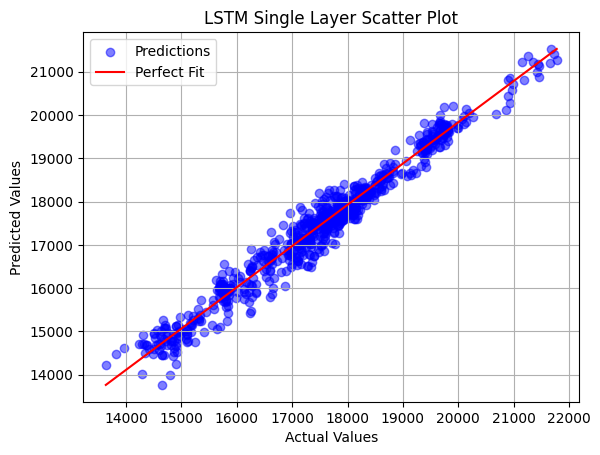

In [56]:
def plot_regression(y_true, y_pred):
  plt.scatter(y_test_actual_LSTM, predictions_LSTM, color='blue', alpha=0.5, label='Predictions')
  plt.plot([min(y_test_actual_LSTM), max(y_test_actual_LSTM)], [min(predictions_LSTM), max(predictions_LSTM)], color='red', linestyle='-', label='Perfect Fit')
  plt.xlabel('Actual Values')
  plt.ylabel('Predicted Values')
  plt.title('LSTM Single Layer Scatter Plot')
  plt.legend()
  plt.grid(True)
  plt.savefig('Scatterplot_LSTM1.png', dpi=600)
  plt.show()

#Scatter plot
plot_regression(y_test_actual_LSTM,predictions_LSTM)

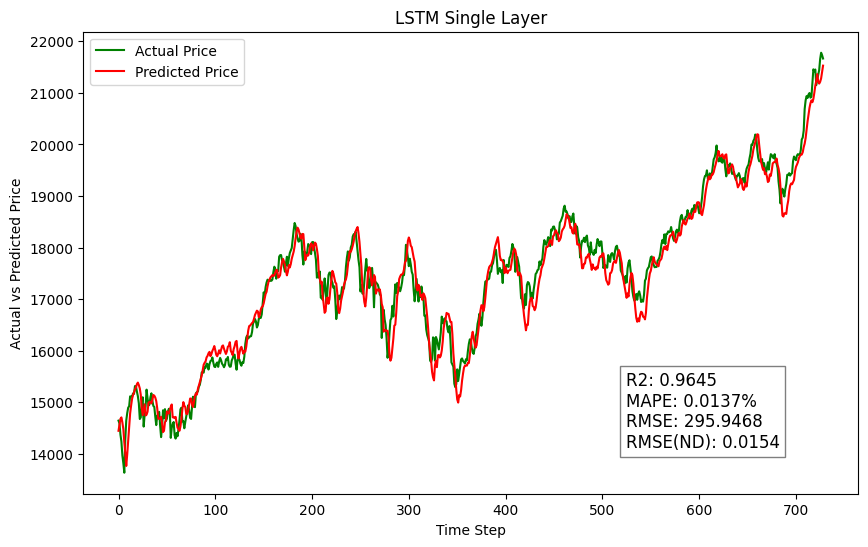

In [57]:
#plot prediction accuracy
plt.figure(figsize=(10, 6))
plt.plot(y_test_actual_LSTM, color='green', label=['Actual Price'])
plt.plot(predictions_LSTM, color='red', label=['Predicted Price'])
plt.legend(['Actual Price', 'Predicted Price'], loc='upper left')

plt.text(0.7, 0.1, f'R2: {r2:.4f}\nMAPE: {mape:.4f}%\nRMSE: {rmse:.4f}\nRMSE(ND): {rmse_normalizeddata:.4f}',
         fontsize=12,
         bbox=dict(facecolor='white', alpha=0.5),
         transform=plt.gca().transAxes)

plt.title('LSTM Single Layer')
plt.xlabel('Time Step')
plt.ylabel('Actual vs Predicted Price')
plt.savefig('lstm1_0.9668.png', dpi=600)  # Saves the plot as a JPG file
plt.show()

##### 4.2 Create and Train the Single-layer GRU model with optimum hyperparameters

In [33]:
model_gru = tf.keras.Sequential()
model_gru.add(tf.keras.layers.GRU(95, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False))
model_gru.add(tf.keras.layers.Dense(1))
model_gru.compile(optimizer=Nadam(learning_rate=0.00016), loss='mse')
#checkpoint = ModelCheckpoint('model_lstmS1.h5', monitor='loss', verbose=1, save_best_only=True)
#early_stopping = EarlyStopping(monitor='loss', patience=5)
model_gru.fit(X_train, y_train, epochs=200, batch_size=54, validation_data=(X_test, y_test), callbacks=[EarlyStopping(monitor='loss', patience=5)])

predictions_gru = model_gru.predict(X_test)
predictions_GRU = scaler.inverse_transform(predictions_gru)
y_test_actual_GRU = scaler.inverse_transform(y_test.reshape(-1, 1))

r2=r2_score(y_test_actual_GRU, predictions_GRU)
print(f"R2: {r2:.4f}")

mape=mean_absolute_percentage_error(y_test_actual_GRU, predictions_GRU)
print(f"MAPE: {mape:.4f}")

mse=mean_squared_error(y_test_actual_GRU, predictions_GRU)
rmse=np.sqrt(mse)
print(f"RMSE: {rmse:.4f}")

mse_normalizeddata=mean_squared_error(y_test, predictions_gru)
rmse_normalizeddata=np.sqrt(mse_normalizeddata)
print(f"RMSE_normalizeddata: {rmse_normalizeddata:.4f}")

mae=mean_absolute_error(y_test_actual_GRU, predictions_GRU)
print(f"MAE: {mae:.4f}")

Epoch 1/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0508 - val_loss: 0.1376
Epoch 2/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0110 - val_loss: 0.0783
Epoch 3/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0051 - val_loss: 0.0453
Epoch 4/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0023 - val_loss: 0.0285
Epoch 5/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0014 - val_loss: 0.0226
Epoch 6/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 9.5697e-04 - val_loss: 0.0191
Epoch 7/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 7.3796e-04 - val_loss: 0.0157
Epoch 8/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 5.7388e-04 - val_loss: 0.0123
Epoch 9/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.3353e-04 - val_loss: 0.0102
Epoch 10/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3.2456e-04 - val_loss: 0.0085
Epoch 11/200
54/54 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 2.5603e-04 - val_loss: 0.0077
Epoch 12/200
54/54 ━━━━━━━━━━━━━━━━━━━

In [34]:
#save every model with their respective r2 score
model_gru.save(f"model_gru1_{r2:.4f}.keras")

In [58]:
#load model with best r2 score
model_gru = load_model('model_gru1_0.9538.keras')
model_gru.predict(X_test)

predictions_gru = model_gru.predict(X_test)
predictions_GRU = scaler.inverse_transform(predictions_gru)
y_test_actual_GRU = scaler.inverse_transform(y_test.reshape(-1, 1))
r2=r2_score(y_test_actual_GRU, predictions_GRU)
print(f"R2: {r2:.4f}")
mape=mean_absolute_percentage_error(y_test_actual_GRU, predictions_GRU)
print(f"MAPE: {mape:.4f}")
mse=mean_squared_error(y_test_actual_GRU, predictions_GRU)
rmse=np.sqrt(mse)
print(f"RMSE: {rmse:.4f}")
mse_normalizeddata=mean_squared_error(y_test, predictions_gru)
rmse_normalizeddata=np.sqrt(mse_normalizeddata)
print(f"RMSE_normalizeddata: {rmse_normalizeddata:.4f}")
mae=mean_absolute_error(y_test_actual_GRU, predictions_GRU)
print(f"MAE: {mae:.4f}")

23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
R2: 0.9538
MAPE: 0.0157
RMSE: 337.6213
RMSE_normalizeddata: 0.0176
MAE: 273.2980


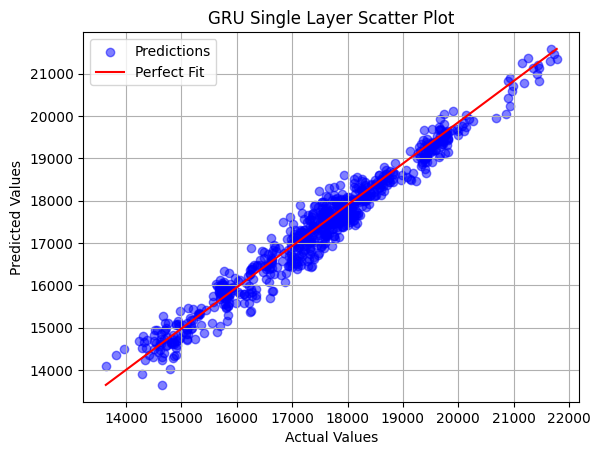

In [59]:
def plot_regression(y_true, y_pred):
  plt.scatter(y_test_actual_GRU, predictions_GRU, color='blue', alpha=0.5, label='Predictions')
  plt.plot([min(y_test_actual_GRU), max(y_test_actual_GRU)], [min(predictions_GRU), max(predictions_GRU)], color='red', linestyle='-', label='Perfect Fit')
  plt.xlabel('Actual Values')
  plt.ylabel('Predicted Values')
  plt.title('GRU Single Layer Scatter Plot')
  plt.legend()
  plt.grid(True)
  plt.savefig('Scatterplot_GRU1.png', dpi=600)
  plt.show()

#Scatter plot
plot_regression(y_test_actual_GRU,predictions_GRU)

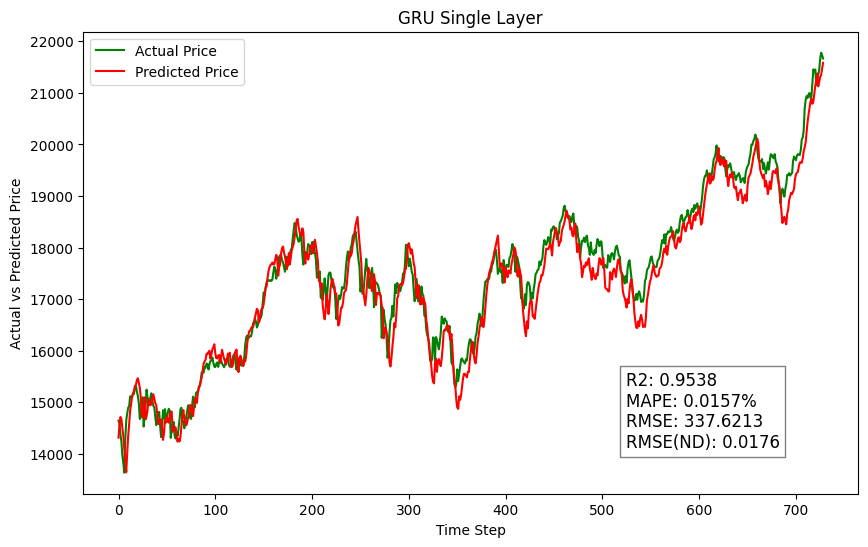

In [60]:
#plot prediction accuracy
plt.figure(figsize=(10, 6))
plt.plot(y_test_actual_GRU, color='green', label=['Actual Price'])
plt.plot(predictions_GRU, color='red', label=['Predicted Price'])
plt.legend(['Actual Price', 'Predicted Price'], loc='upper left')

plt.text(0.7, 0.1, f'R2: {r2:.4f}\nMAPE: {mape:.4f}%\nRMSE: {rmse:.4f}\nRMSE(ND): {rmse_normalizeddata:.4f}', 
         fontsize=12, 
         bbox=dict(facecolor='white', alpha=0.5),
         transform=plt.gca().transAxes)

plt.title('GRU Single Layer')
plt.xlabel('Time Step')
plt.ylabel('Actual vs Predicted Price')
plt.savefig('gru1_0.9538.png', dpi=600) 
plt.show()

##### 4.3 Create and Train the Single-layer GRU-LSTM model with optimum hyperparameters

In [29]:
model_grulstm = tf.keras.Sequential()
model_grulstm.add(tf.keras.layers.GRU(158, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model_grulstm.add(tf.keras.layers.LSTM(209, activation='relu', return_sequences=False))
model_grulstm.add(tf.keras.layers.Dense(1))
model_grulstm.compile(optimizer=Nadam(learning_rate=0.000187), loss='mse')
early_stopping = EarlyStopping(monitor='loss', patience=5)
model_grulstm.fit(X_train, y_train, epochs=200, batch_size=20, validation_data=(X_test, y_test), callbacks=[EarlyStopping(monitor='loss', patience=5)])

predictions_grulstm = model_grulstm.predict(X_test)
predictions_GRULSTM = scaler.inverse_transform(predictions_grulstm)
y_test_actual_GRULSTM = scaler.inverse_transform(y_test.reshape(-1, 1))

r2=r2_score(y_test_actual_GRULSTM, predictions_GRULSTM)
print(f"R2: {r2:.4f}")

mape=mean_absolute_percentage_error(y_test_actual_GRULSTM, predictions_GRULSTM)
print(f"MAPE: {mape:.4f}")

mse=mean_squared_error(y_test_actual_GRULSTM, predictions_GRULSTM)
print(f"MSE: {mse:.4f}")

rmse=np.sqrt(mse)
print(f"RMSE: {rmse:.4f}")

mae=mean_absolute_error(y_test_actual_GRULSTM, predictions_GRULSTM)
print(f"MAE: {mae:.4f}")

mse_n=mean_squared_error(y_test, predictions_grulstm)
rmse_n=np.sqrt(mse_n)
print(f"RMSE of Normalized Data: {rmse_n:.4f}")

Epoch 1/200
146/146 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - loss: 0.0318 - val_loss: 0.0152
Epoch 2/200
146/146 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 4.6700e-04 - val_loss: 0.0059
Epoch 3/200
146/146 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 1.6496e-04 - val_loss: 0.0048
Epoch 4/200
146/146 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.0433e-04 - val_loss: 0.0041
Epoch 5/200
146/146 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 9.3885e-05 - val_loss: 0.0051
Epoch 6/200
146/146 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 7.3595e-05 - val_loss: 0.0040
Epoch 7/200
146/146 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 6.7787e-05 - val_loss: 0.0037
Epoch 8/200
146/146 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 6.4523e-05 - val_loss: 0.0049
Epoch 9/200
146/146 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 5.8827e-05 - val_loss: 0.0037
Epoch 10/200
146/146 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 5.9585e-05 - val_loss: 0.0045
Epoch 11/200
146/146 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 5.3436e-05 - val_los

In [ ]:
#save every model with their respective r2 score
model_grulstm.save(f"model_grulstm1_{r2:.4f}.keras")

In [61]:
#load model with best r2 score
model_grulstm = load_model('model_grulstm1_0.9233.keras')
model_grulstm.predict(X_test)

predictions_grulstm = model_grulstm.predict(X_test)
predictions_GRULSTM = scaler.inverse_transform(predictions_grulstm)
y_test_actual_GRULSTM = scaler.inverse_transform(y_test.reshape(-1, 1))

r2=r2_score(y_test_actual_GRULSTM, predictions_GRULSTM)
print(f"R2: {r2:.4f}")

mape=mean_absolute_percentage_error(y_test_actual_GRULSTM, predictions_GRULSTM)
print(f"MAPE: {mape:.4f}")

mse=mean_squared_error(y_test_actual_GRULSTM, predictions_GRULSTM)
print(f"MSE: {mse:.4f}")

rmse=np.sqrt(mse)
print(f"RMSE: {rmse:.4f}")

mae=mean_absolute_error(y_test_actual_GRULSTM, predictions_GRULSTM)
print(f"MAE: {mae:.4f}")

mse_n=mean_squared_error(y_test, predictions_grulstm)
rmse_n=np.sqrt(mse_n)
print(f"RMSE of Normalized Data: {rmse_n:.4f}")

23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
R2: 0.9233
MAPE: 0.0198
MSE: 189277.9345
RMSE: 435.0608
MAE: 343.8341
RMSE of Normalized Data: 0.0227


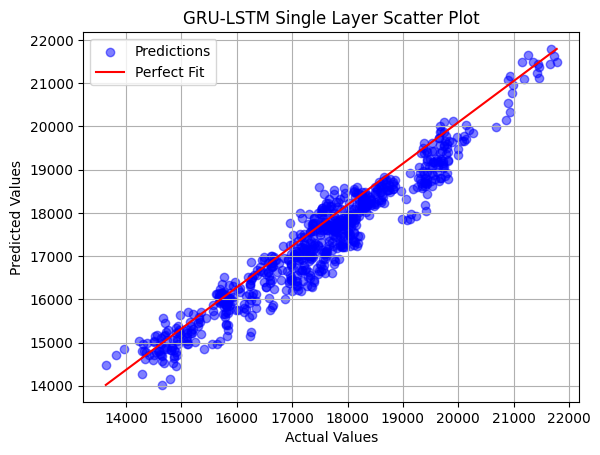

In [62]:
def plot_regression(y_true, y_pred):
  plt.scatter(y_test_actual_GRULSTM, predictions_GRULSTM, color='blue', alpha=0.5, label='Predictions')
  plt.plot([min(y_test_actual_GRULSTM), max(y_test_actual_GRULSTM)], [min(predictions_GRULSTM), max(predictions_GRULSTM)], color='red', linestyle='-', label='Perfect Fit')
  plt.xlabel('Actual Values')
  plt.ylabel('Predicted Values')
  plt.title('GRU-LSTM Single Layer Scatter Plot')
  plt.legend()
  plt.grid(True)
  plt.savefig('Scatterplot_GRULSTM1.png', dpi=600)
  plt.show()

#Scatter plot
plot_regression(y_test_actual_GRULSTM,predictions_GRULSTM)

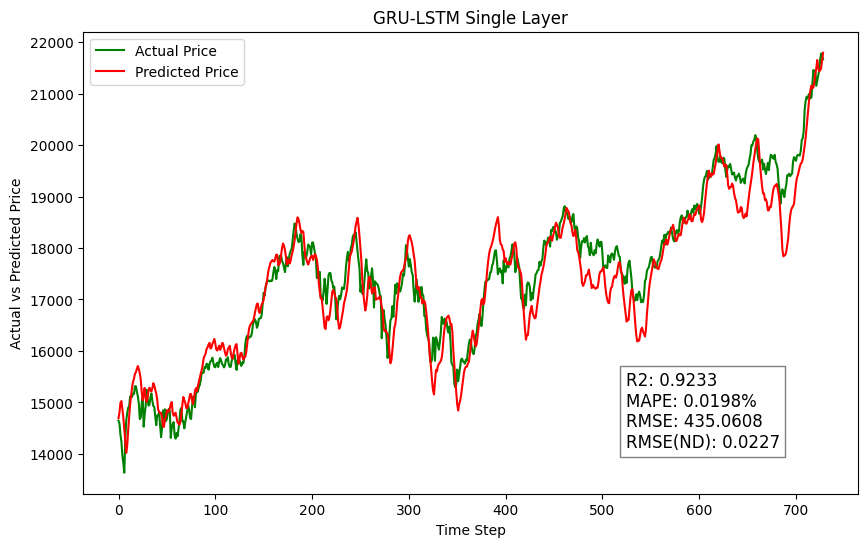

In [63]:
#plot prediction accuracy
plt.figure(figsize=(10, 6))
plt.plot(y_test_actual_GRULSTM, color='green', label=['Actual Price'])
plt.plot(predictions_GRULSTM, color='red', label=['Predicted Price'])
plt.legend(['Actual Price', 'Predicted Price'], loc='upper left')

plt.text(0.7, 0.1, f'R2: {r2:.4f}\nMAPE: {mape:.4f}%\nRMSE: {rmse:.4f}\nRMSE(ND): {rmse_n:.4f}',
         fontsize=12,
         bbox=dict(facecolor='white', alpha=0.5),
         transform=plt.gca().transAxes)

plt.title('GRU-LSTM Single Layer')
plt.xlabel('Time Step')
plt.ylabel('Actual vs Predicted Price')
plt.savefig('grulstm1_0.9233.png', dpi=600) 
plt.show()

##### 4.4 Create and Train the Single-layer LSTM-GRU model with optimum hyperparameters

In [ ]:
model_lstmgru = tf.keras.Sequential()
model_lstmgru.add(tf.keras.layers.LSTM(164, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model_lstmgru.add(tf.keras.layers.GRU(52, activation='relu', return_sequences=False))
model_lstmgru.add(tf.keras.layers.Dense(1))
model_lstmgru.compile(optimizer=Nadam(learning_rate=0.0004), loss='mse')
early_stopping = EarlyStopping(monitor='loss', patience=5)
model_lstmgru.fit(X_train, y_train, epochs=200, batch_size=66, validation_data=(X_test, y_test), callbacks=[EarlyStopping(monitor='loss', patience=5)])

predictions_lstmgru = model_lstmgru.predict(X_test)
predictions_LSTMGRU = scaler.inverse_transform(predictions_lstmgru)
y_test_actual_LSTMGRU = scaler.inverse_transform(y_test.reshape(-1, 1))

dates_test=df['Date'].iloc[split + n_steps:]
r2=r2_score(y_test_actual_LSTMGRU, predictions_LSTMGRU)
print(f"R2: {r2:.4f}")

mape=mean_absolute_percentage_error(y_test_actual_LSTMGRU, predictions_LSTMGRU)
print(f"MAPE: {mape:.4f}")

mse=mean_squared_error(y_test_actual_LSTMGRU, predictions_LSTMGRU)
print(f"MSE: {mse:.4f}")
rmse=np.sqrt(mse)
print(f"RMSE: {rmse:.4f}")

mae=mean_absolute_error(y_test_actual_LSTMGRU, predictions_LSTMGRU)
print(f"MAE: {mae:.4f}")

mse_n=mean_squared_error(y_test, predictions_lstmgru)
rmse_n=np.sqrt(mse_n)
print(f"RMSE of Normalized Data: {rmse_n:.4f}")

In [ ]:
#save every model with their respective r2 score
model_lstmgru.save(f"model_lstmgru1_{r2:.4f}.keras")

In [64]:
#load model with best r2 score
model_lstmgru = load_model('model_lstmgru1_0.9371.keras')
model_lstmgru.predict(X_test)

predictions_lstmgru = model_lstmgru.predict(X_test)
predictions_LSTMGRU = scaler.inverse_transform(predictions_lstmgru)
y_test_actual_LSTMGRU = scaler.inverse_transform(y_test.reshape(-1, 1))

dates_test=df['Date'].iloc[split + n_steps:]
r2=r2_score(y_test_actual_LSTMGRU, predictions_LSTMGRU)
print(f"R2: {r2:.4f}")

mape=mean_absolute_percentage_error(y_test_actual_LSTMGRU, predictions_LSTMGRU)
print(f"MAPE: {mape:.4f}")

mse=mean_squared_error(y_test_actual_LSTMGRU, predictions_LSTMGRU)
print(f"MSE: {mse:.4f}")
rmse=np.sqrt(mse)
print(f"RMSE: {rmse:.4f}")

mae=mean_absolute_error(y_test_actual_LSTMGRU, predictions_LSTMGRU)
print(f"MAE: {mae:.4f}")

mse_n=mean_squared_error(y_test, predictions_lstmgru)
rmse_n=np.sqrt(mse_n)
print(f"RMSE of Normalized Data: {rmse_n:.4f}")

23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
R2: 0.9371
MAPE: 0.0177
MSE: 155240.7246
RMSE: 394.0060
MAE: 307.2026
RMSE of Normalized Data: 0.0205


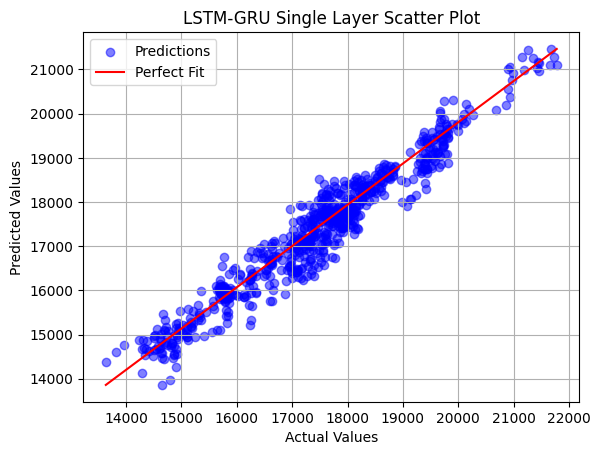

In [65]:
def plot_regression(y_true, y_pred):
  plt.scatter(y_test_actual_LSTMGRU, predictions_LSTMGRU, color='blue', alpha=0.5, label='Predictions')
  plt.plot([min(y_test_actual_LSTMGRU), max(y_test_actual_LSTMGRU)], [min(predictions_LSTMGRU), max(predictions_LSTMGRU)], color='red', linestyle='-', label='Perfect Fit')
  plt.xlabel('Actual Values')
  plt.ylabel('Predicted Values')
  plt.title('LSTM-GRU Single Layer Scatter Plot')
  plt.legend()
  plt.grid(True)
  plt.savefig('Scatterplot_LSTMGRU1.png', dpi=600)
  plt.show()

#Scatter plot
plot_regression(y_test_actual_LSTMGRU,predictions_LSTMGRU)

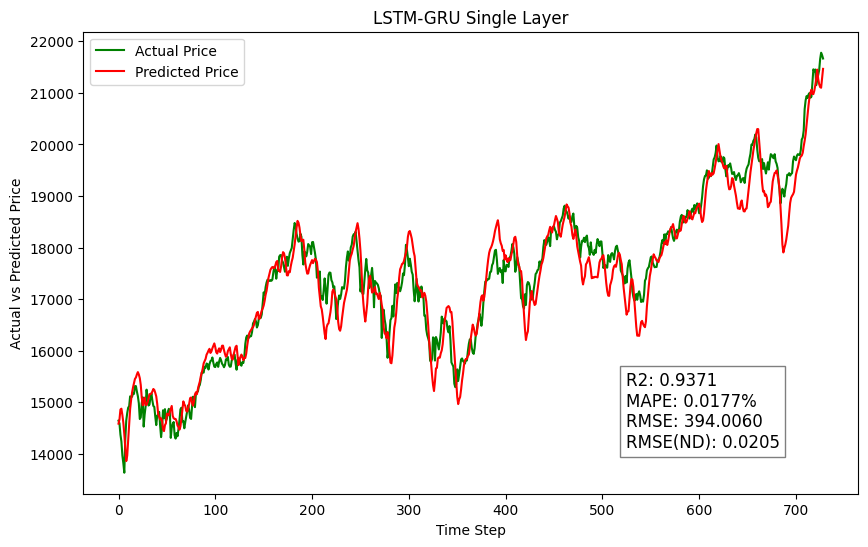

In [66]:
#plot prediction accuracy
plt.figure(figsize=(10, 6))
plt.plot(y_test_actual_LSTMGRU, color='green', label=['Actual Price'])
plt.plot(predictions_LSTMGRU, color='red', label=['Predicted Price'])
plt.legend(['Actual Price', 'Predicted Price'], loc='upper left')

plt.text(0.7, 0.1, f'R2: {r2:.4f}\nMAPE: {mape:.4f}%\nRMSE: {rmse:.4f}\nRMSE(ND): {rmse_n:.4f}',
         fontsize=12,
         bbox=dict(facecolor='white', alpha=0.5),
         transform=plt.gca().transAxes)

plt.title('LSTM-GRU Single Layer')
plt.xlabel('Time Step')
plt.ylabel('Actual vs Predicted Price')
plt.savefig('lstmgru1_0.9371.png', dpi=900)  
plt.show()

##### 4.5 Create and Train the Double-layer LSTM model with optimum hyperparameters

In [ ]:
model_lstm = tf.keras.Sequential()
model_lstm.add(tf.keras.layers.LSTM(357, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model_lstm.add(tf.keras.layers.LSTM(250, activation='relu', return_sequences=False))
model_lstm.add(tf.keras.layers.Dense(1))
model_lstm.compile(optimizer=Nadam(learning_rate=0.0014), loss='mse')
#checkpoint = ModelCheckpoint('model_lstmS1.h5', monitor='loss', verbose=1, save_best_only=True)
early_stopping = EarlyStopping(monitor='loss', patience=5)
model_lstm.fit(X_train, y_train, epochs=200, batch_size=22, validation_data=(X_test, y_test), callbacks=[EarlyStopping(monitor='loss', patience=5)])

predictions_lstm = model_lstm.predict(X_test)
predictions_LSTM = scaler.inverse_transform(predictions_lstm)
y_test_actual_LSTM = scaler.inverse_transform(y_test.reshape(-1, 1))

r2=r2_score(y_test_actual_LSTM, predictions_LSTM)
print(f"R2: {r2:.4f}")

mape=mean_absolute_percentage_error(y_test_actual_LSTM, predictions_LSTM)
print(f"MAPE: {mape:.4f}")

mse=mean_squared_error(y_test_actual_LSTM, predictions_LSTM)
rmse=np.sqrt(mse)
print(f"RMSE: {rmse:.4f}")

mse_normalizeddata=mean_squared_error(y_test, predictions_lstm)
rmse_normalizeddata=np.sqrt(mse_normalizeddata)
print(f"RMSE_normalizeddata: {rmse_normalizeddata:.4f}")

mae=mean_absolute_error(y_test_actual_LSTM, predictions_LSTM)
print(f"MAE: {mae:.4f}")

In [ ]:
#save every model with their respective r2 score
model_lstm.save(f"model_lstm2_{r2:.4f}.keras")

In [67]:
#load model with best r2 score
model_lstm = load_model('model_lstm2_0.9416.keras')
model_lstm.predict(X_test)

predictions_lstm = model_lstm.predict(X_test)
predictions_LSTM = scaler.inverse_transform(predictions_lstm)
y_test_actual_LSTM = scaler.inverse_transform(y_test.reshape(-1, 1))

r2=r2_score(y_test_actual_LSTM, predictions_LSTM)
print(f"R2: {r2:.4f}")

mape=mean_absolute_percentage_error(y_test_actual_LSTM, predictions_LSTM)
print(f"MAPE: {mape:.4f}")

mse=mean_squared_error(y_test_actual_LSTM, predictions_LSTM)
rmse=np.sqrt(mse)
print(f"RMSE: {rmse:.4f}")

mse_normalizeddata=mean_squared_error(y_test, predictions_lstm)
rmse_normalizeddata=np.sqrt(mse_normalizeddata)
print(f"RMSE_normalizeddata: {rmse_normalizeddata:.4f}")

mae=mean_absolute_error(y_test_actual_LSTM, predictions_LSTM)
print(f"MAE: {mae:.4f}")

23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
R2: 0.9416
MAPE: 0.0180
RMSE: 379.8445
RMSE_normalizeddata: 0.0198
MAE: 310.8498


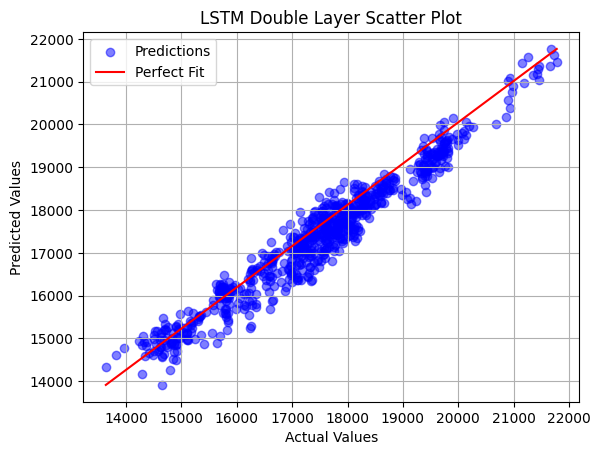

In [68]:
def plot_regression(y_true, y_pred):
  plt.scatter(y_test_actual_LSTM, predictions_LSTM, color='blue', alpha=0.5, label='Predictions')
  plt.plot([min(y_test_actual_LSTM), max(y_test_actual_LSTM)], [min(predictions_LSTM), max(predictions_LSTM)], color='red', linestyle='-', label='Perfect Fit')
  plt.xlabel('Actual Values')
  plt.ylabel('Predicted Values')
  plt.title('LSTM Double Layer Scatter Plot')
  plt.legend()
  plt.grid(True)
  plt.savefig('Scatterplot_LSTM2.png', dpi=600)
  plt.show()

#Scatter plot
plot_regression(y_test_actual_LSTM,predictions_LSTM)

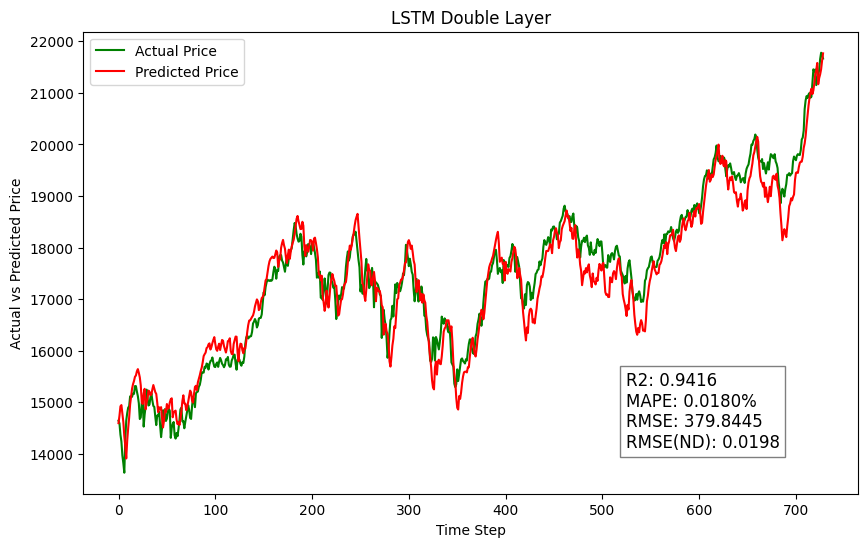

In [69]:
#plot prediction accuracy
plt.figure(figsize=(10, 6))
plt.plot(y_test_actual_LSTM, color='green', label=['Actual Price'])
plt.plot(predictions_LSTM, color='red', label=['Predicted Price'])
plt.legend(['Actual Price', 'Predicted Price'], loc='upper left')

plt.text(0.7, 0.1, f'R2: {r2:.4f}\nMAPE: {mape:.4f}%\nRMSE: {rmse:.4f}\nRMSE(ND): {rmse_normalizeddata:.4f}',
         fontsize=12,
         bbox=dict(facecolor='white', alpha=0.5),
         transform=plt.gca().transAxes)

plt.title('LSTM Double Layer')
plt.xlabel('Time Step')
plt.ylabel('Actual vs Predicted Price')
plt.savefig('lstm2_0.9668.png', dpi=600)  
plt.show()

##### 4.6 Create and Train the Double-layer GRU model with optimum hyperparameters

In [ ]:
model_gru = tf.keras.Sequential()
model_gru.add(tf.keras.layers.LSTM(394, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model_gru.add(tf.keras.layers.LSTM(451, activation='relu', return_sequences=False))
model_gru.add(tf.keras.layers.Dense(1))
model_gru.compile(optimizer=Nadam(learning_rate=0.00992), loss='mse')
#checkpoint = ModelCheckpoint('model_lstmS1.h5', monitor='loss', verbose=1, save_best_only=True)
early_stopping = EarlyStopping(monitor='loss', patience=3)
model_gru.fit(X_train, y_train, epochs=200, batch_size=37, validation_data=(X_test, y_test), callbacks=[EarlyStopping(monitor='loss', patience=5)])

predictions_gru = model_gru.predict(X_test)
predictions_GRU = scaler.inverse_transform(predictions_gru)
y_test_actual_GRU = scaler.inverse_transform(y_test.reshape(-1, 1))

r2=r2_score(y_test_actual_GRU, predictions_GRU)
print(f"R2: {r2:.4f}")

mape=mean_absolute_percentage_error(y_test_actual_GRU, predictions_GRU)
print(f"MAPE: {mape:.4f}")

mse=mean_squared_error(y_test_actual_GRU, predictions_GRU)
rmse=np.sqrt(mse)
print(f"RMSE: {rmse:.4f}")

mse_normalizeddata=mean_squared_error(y_test, predictions_gru)
rmse_normalizeddata=np.sqrt(mse_normalizeddata)
print(f"RMSE_normalizeddata: {rmse_normalizeddata:.4f}")

mae=mean_absolute_error(y_test_actual_GRU, predictions_GRU)
print(f"MAE: {mae:.4f}")

In [ ]:
#save every model with their respective r2 score
model_lstm.save(f"model_gru2_{r2:.4f}.keras")

In [70]:
#load model with best r2 score
model_gru = load_model('model_gru2_0.9524.keras')
model_gru.predict(X_test)

predictions_gru = model_gru.predict(X_test)
predictions_GRU = scaler.inverse_transform(predictions_gru)
y_test_actual_GRU = scaler.inverse_transform(y_test.reshape(-1, 1))
r2=r2_score(y_test_actual_GRU, predictions_GRU)
print(f"R2: {r2:.4f}")
mape=mean_absolute_percentage_error(y_test_actual_GRU, predictions_GRU)
print(f"MAPE: {mape:.4f}")
mse=mean_squared_error(y_test_actual_GRU, predictions_GRU)
rmse=np.sqrt(mse)
print(f"RMSE: {rmse:.4f}")
mse_normalizeddata=mean_squared_error(y_test, predictions_gru)
rmse_normalizeddata=np.sqrt(mse_normalizeddata)
print(f"RMSE_normalizeddata: {rmse_normalizeddata:.4f}")
mae=mean_absolute_error(y_test_actual_GRU, predictions_GRU)
print(f"MAE: {mae:.4f}")

23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
R2: 0.9524
MAPE: 0.0160
RMSE: 342.6774
RMSE_normalizeddata: 0.0178
MAE: 275.4691


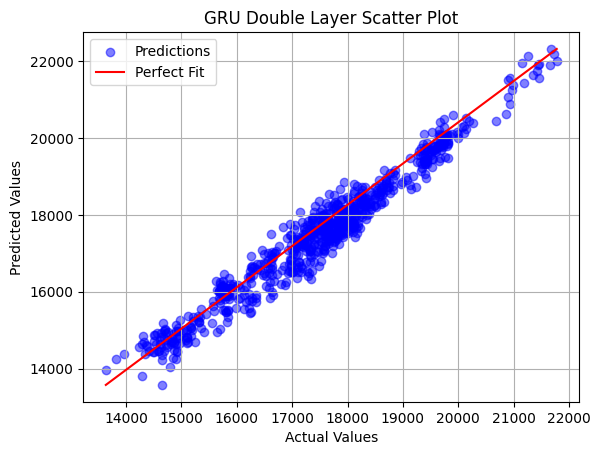

In [71]:
def plot_regression(y_true, y_pred):
  plt.scatter(y_test_actual_GRU, predictions_GRU, color='blue', alpha=0.5, label='Predictions')
  plt.plot([min(y_test_actual_GRU), max(y_test_actual_GRU)], [min(predictions_GRU), max(predictions_GRU)], color='red', linestyle='-', label='Perfect Fit')
  plt.xlabel('Actual Values')
  plt.ylabel('Predicted Values')
  plt.title('GRU Double Layer Scatter Plot')
  plt.legend()
  plt.grid(True)
  plt.savefig('Scatterplot_GRU2.png', dpi=600)
  plt.show()

#Scatter plot
plot_regression(y_test_actual_GRU,predictions_GRU)

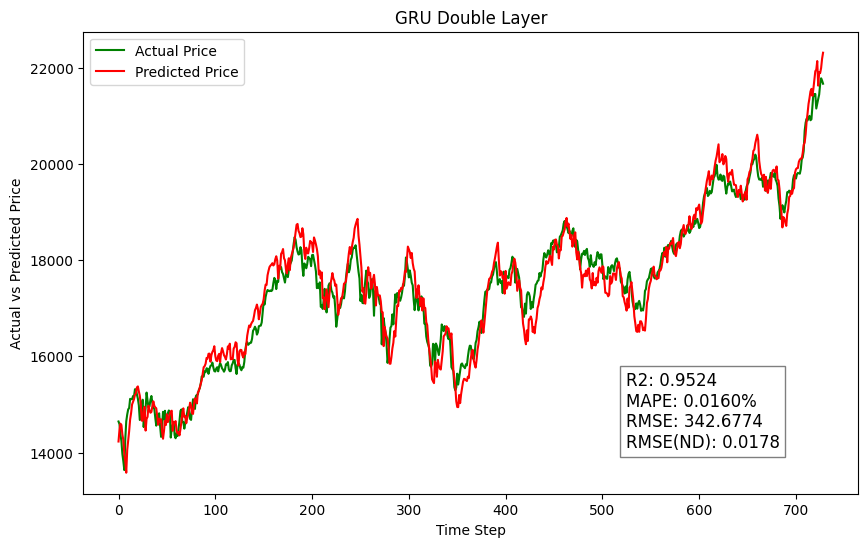

In [72]:
#plot prediction accuracy
plt.figure(figsize=(10, 6))
plt.plot(y_test_actual_GRU, color='green', label=['Actual Price'])
plt.plot(predictions_GRU, color='red', label=['Predicted Price'])
plt.legend(['Actual Price', 'Predicted Price'], loc='upper left')

plt.text(0.7, 0.1, f'R2: {r2:.4f}\nMAPE: {mape:.4f}%\nRMSE: {rmse:.4f}\nRMSE(ND): {rmse_normalizeddata:.4f}', 
         fontsize=12, 
         bbox=dict(facecolor='white', alpha=0.5),
         transform=plt.gca().transAxes)

plt.title('GRU Double Layer')
plt.xlabel('Time Step')
plt.ylabel('Actual vs Predicted Price')
plt.savefig('gru2_9307.png', dpi=600)  
plt.show()

##### 4.7 Create and Train the Double-layer GRU-LSTM model with optimum hyperparameters

In [ ]:
model_grulstm = tf.keras.Sequential()
model_grulstm.add(tf.keras.layers.GRU(437, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model_grulstm.add(tf.keras.layers.LSTM(252, activation='relu', return_sequences=True))
model_grulstm.add(tf.keras.layers.GRU(68, activation='relu', return_sequences=True))
model_grulstm.add(tf.keras.layers.LSTM(511, activation='relu', return_sequences=False))
model_grulstm.add(tf.keras.layers.Dense(1))
model_grulstm.compile(optimizer=Nadam(learning_rate=0.0001), loss='mse')
#checkpoint = ModelCheckpoint('model_grulstmS1.h5', monitor='loss', verbose=1, save_best_only=True)
early_stopping = EarlyStopping(monitor='loss', patience=5)
model_grulstm.fit(X_train, y_train, epochs=200, batch_size=102, validation_data=(X_test, y_test), callbacks=[EarlyStopping(monitor='loss', patience=5)])

predictions_grulstm = model_grulstm.predict(X_test)
predictions_GRULSTM = scaler.inverse_transform(predictions_grulstm)
y_test_actual_GRULSTM = scaler.inverse_transform(y_test.reshape(-1, 1))

r2=r2_score(y_test_actual_GRULSTM, predictions_GRULSTM)
print(f"R2: {r2:.4f}")

mape=mean_absolute_percentage_error(y_test_actual_GRULSTM, predictions_GRULSTM)
print(f"MAPE: {mape:.4f}")

mse=mean_squared_error(y_test_actual_GRULSTM, predictions_GRULSTM)
print(f"MSE: {mse:.4f}")
rmse=np.sqrt(mse)
print(f"RMSE: {rmse:.4f}")

mae=mean_absolute_error(y_test_actual_GRULSTM, predictions_GRULSTM)
print(f"MAE: {mae:.4f}")

mse_n=mean_squared_error(y_test, predictions_grulstm)
rmse_n=np.sqrt(mse_n)
print(f"RMSE of Normalized Data: {rmse_n:.4f}")

In [ ]:
#save every model with their respective r2 score
model_grulstm.save(f"model_grulstm2_{r2:.4f}.keras")

In [73]:
#load model with best r2 score
model_grulstm = load_model('model_grulstm2_0.9249.keras')
model_grulstm.predict(X_test)

predictions_grulstm = model_grulstm.predict(X_test)
predictions_GRULSTM = scaler.inverse_transform(predictions_grulstm)
y_test_actual_GRULSTM = scaler.inverse_transform(y_test.reshape(-1, 1))

r2=r2_score(y_test_actual_GRULSTM, predictions_GRULSTM)
print(f"R2: {r2:.4f}")

mape=mean_absolute_percentage_error(y_test_actual_GRULSTM, predictions_GRULSTM)
print(f"MAPE: {mape:.4f}")

mse=mean_squared_error(y_test_actual_GRULSTM, predictions_GRULSTM)
print(f"MSE: {mse:.4f}")
rmse=np.sqrt(mse)
print(f"RMSE: {rmse:.4f}")

mae=mean_absolute_error(y_test_actual_GRULSTM, predictions_GRULSTM)
print(f"MAE: {mae:.4f}")

mse_n=mean_squared_error(y_test, predictions_grulstm)
rmse_n=np.sqrt(mse_n)
print(f"RMSE of Normalized Data: {rmse_n:.4f}")

23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
R2: 0.9249
MAPE: 0.0193
MSE: 185508.6235
RMSE: 430.7071
MAE: 335.1118
RMSE of Normalized Data: 0.0224


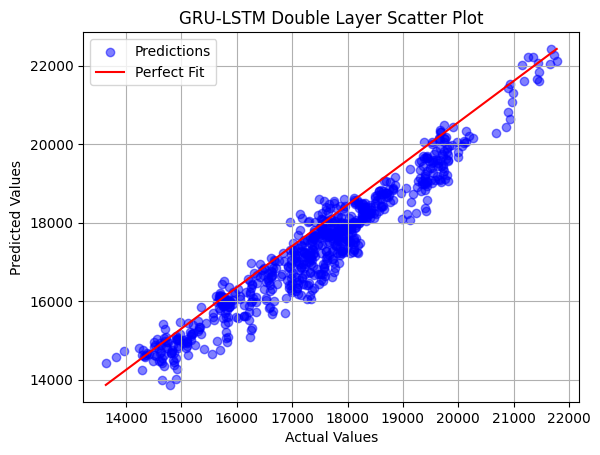

In [74]:
def plot_regression(y_true, y_pred):
  plt.scatter(y_test_actual_GRULSTM, predictions_GRULSTM, color='blue', alpha=0.5, label='Predictions')
  plt.plot([min(y_test_actual_GRULSTM), max(y_test_actual_GRULSTM)], [min(predictions_GRULSTM), max(predictions_GRULSTM)], color='red', linestyle='-', label='Perfect Fit')
  plt.xlabel('Actual Values')
  plt.ylabel('Predicted Values')
  plt.title('GRU-LSTM Double Layer Scatter Plot')
  plt.legend()
  plt.grid(True)
  plt.savefig('Scatterplot_GRULSTM2.png', dpi=600)
  plt.show()

#Scatter plot
plot_regression(y_test_actual_GRULSTM,predictions_GRULSTM)

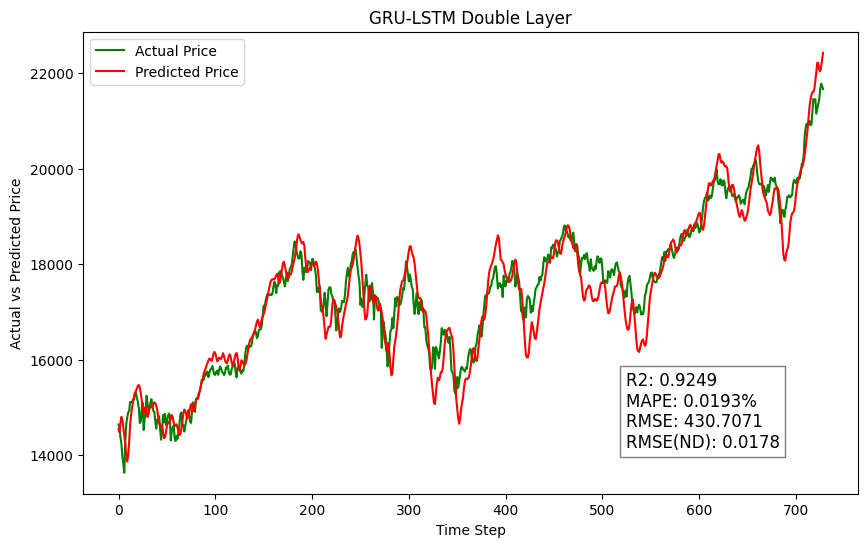

In [75]:
#plot prediction accuracy
plt.figure(figsize=(10, 6))
plt.plot(y_test_actual_GRULSTM, color='green', label=['Actual Price'])
plt.plot(predictions_GRULSTM, color='red', label=['Predicted Price'])
plt.legend(['Actual Price', 'Predicted Price'], loc='upper left')

plt.text(0.7, 0.1, f'R2: {r2:.4f}\nMAPE: {mape:.4f}%\nRMSE: {rmse:.4f}\nRMSE(ND): {rmse_normalizeddata:.4f}',
         fontsize=12,
         bbox=dict(facecolor='white', alpha=0.5),
         transform=plt.gca().transAxes)

plt.title('GRU-LSTM Double Layer')
plt.xlabel('Time Step')
plt.ylabel('Actual vs Predicted Price')
plt.savefig('grulstm2_0.9249.png', dpi=600)  
plt.show()

##### 4.8 Create and Train the Double-layer LSTM-GRU model with optimum hyperparameters

In [ ]:
model_lstmgru = tf.keras.Sequential()
model_lstmgru.add(tf.keras.layers.LSTM(230, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model_lstmgru.add(tf.keras.layers.GRU(132, activation='relu', return_sequences=True))
model_lstmgru.add(tf.keras.layers.LSTM(108, activation='relu', return_sequences=True))
model_lstmgru.add(tf.keras.layers.GRU(105, activation='relu', return_sequences=False))
model_lstmgru.add(tf.keras.layers.Dense(1))
model_lstmgru.compile(optimizer=Nadam(learning_rate=0.00034), loss='mse')
#checkpoint = ModelCheckpoint('model_grulstmS2.h5', monitor='loss', verbose=1, save_best_only=True)
early_stopping = EarlyStopping(monitor='loss', patience=5)
model_lstmgru.fit(X_train, y_train, epochs=200, batch_size=22, validation_data=(X_test, y_test), callbacks=[EarlyStopping(monitor='loss', patience=5)])

predictions_lstmgru = model_lstmgru.predict(X_test)
predictions_LSTMGRU = scaler.inverse_transform(predictions_lstmgru)
y_test_actual_LSTMGRU = scaler.inverse_transform(y_test.reshape(-1, 1))

dates_test=df['Date'].iloc[split + n_steps:]
r2=r2_score(y_test_actual_LSTMGRU, predictions_LSTMGRU)
print(f"R2: {r2:.4f}")

mape=mean_absolute_percentage_error(y_test_actual_LSTMGRU, predictions_LSTMGRU)
print(f"MAPE: {mape:.4f}")

mse=mean_squared_error(y_test_actual_LSTMGRU, predictions_LSTMGRU)
print(f"MSE: {mse:.4f}")
rmse=np.sqrt(mse)
print(f"RMSE: {rmse:.4f}")

mae=mean_absolute_error(y_test_actual_LSTMGRU, predictions_LSTMGRU)
print(f"MAE: {mae:.4f}")

mse_n=mean_squared_error(y_test, predictions_lstmgru)
rmse_n=np.sqrt(mse_n)
print(f"RMSE of Normalized Data: {rmse_n:.4f}")

In [ ]:
#save every model with their respective r2 score
model_lstmgru.save(f"model_lstmgru2_{r2:.4f}.keras")

In [76]:
#load model with best r2 score
model_lstmgru = load_model('model_lstmgru2_0.9357.keras')
model_lstmgru.predict(X_test)

predictions_lstmgru = model_lstmgru.predict(X_test)
predictions_LSTMGRU = scaler.inverse_transform(predictions_lstmgru)
y_test_actual_LSTMGRU = scaler.inverse_transform(y_test.reshape(-1, 1))

dates_test=df['Date'].iloc[split + n_steps:]
r2=r2_score(y_test_actual_LSTMGRU, predictions_LSTMGRU)
print(f"R2: {r2:.4f}")

mape=mean_absolute_percentage_error(y_test_actual_LSTMGRU, predictions_LSTMGRU)
print(f"MAPE: {mape:.4f}")

mse=mean_squared_error(y_test_actual_LSTMGRU, predictions_LSTMGRU)
print(f"MSE: {mse:.4f}")
rmse=np.sqrt(mse)
print(f"RMSE: {rmse:.4f}")

mae=mean_absolute_error(y_test_actual_LSTMGRU, predictions_LSTMGRU)
print(f"MAE: {mae:.4f}")

mse_n=mean_squared_error(y_test, predictions_lstmgru)
rmse_n=np.sqrt(mse_n)
print(f"RMSE of Normalized Data: {rmse_n:.4f}")

23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
R2: 0.9357
MAPE: 0.0177
MSE: 158784.0092
RMSE: 398.4771
MAE: 309.1403
RMSE of Normalized Data: 0.0207


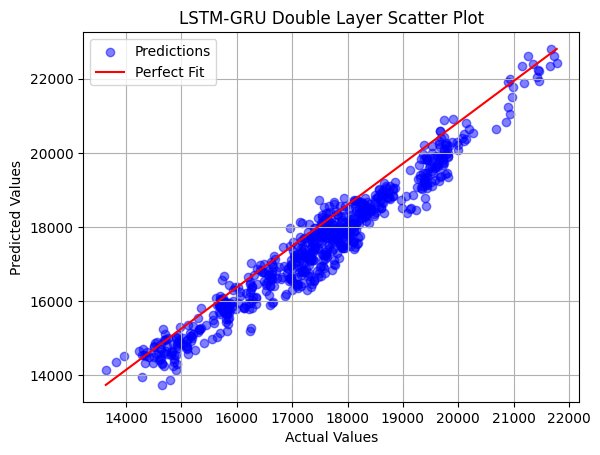

In [77]:
def plot_regression(y_true, y_pred):
  plt.scatter(y_test_actual_LSTMGRU, predictions_LSTMGRU, color='blue', alpha=0.5, label='Predictions')
  plt.plot([min(y_test_actual_LSTMGRU), max(y_test_actual_LSTMGRU)], [min(predictions_LSTMGRU), max(predictions_LSTMGRU)], color='red', linestyle='-', label='Perfect Fit')
  plt.xlabel('Actual Values')
  plt.ylabel('Predicted Values')
  plt.title('LSTM-GRU Double Layer Scatter Plot')
  plt.legend()
  plt.grid(True)
  plt.savefig('Scatterplot_LSTMGRU2.png', dpi=600)
  plt.show()

#Scatter plot
plot_regression(y_test_actual_LSTMGRU,predictions_LSTMGRU)

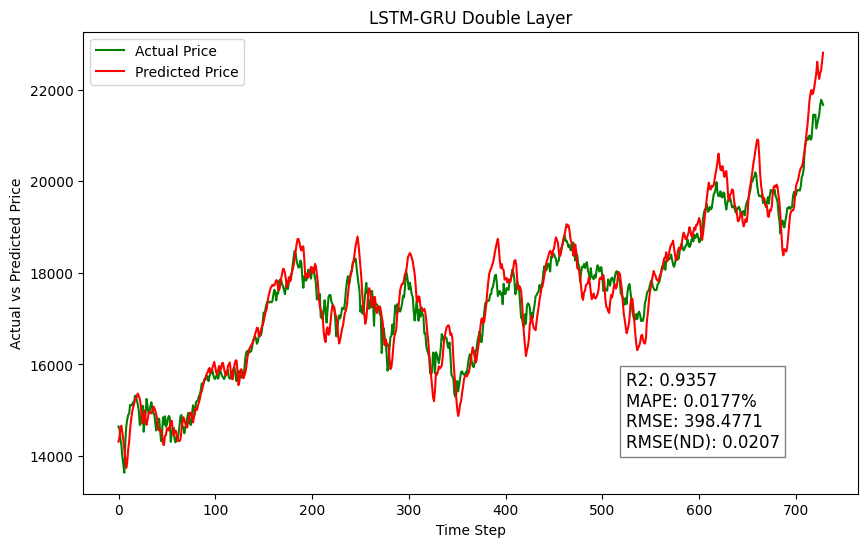

In [78]:
#plot prediction accuracy
plt.figure(figsize=(10, 6))
plt.plot(y_test_actual_LSTMGRU, color='green', label=['Actual Price'])
plt.plot(predictions_LSTMGRU, color='red', label=['Predicted Price'])
plt.legend(['Actual Price', 'Predicted Price'], loc='upper left')

plt.text(0.7, 0.1, f'R2: {r2:.4f}\nMAPE: {mape:.4f}%\nRMSE: {rmse:.4f}\nRMSE(ND): {rmse_n:.4f}',
         fontsize=12,
         bbox=dict(facecolor='white', alpha=0.5),
         transform=plt.gca().transAxes)

plt.title('LSTM-GRU Double Layer')
plt.xlabel('Time Step')
plt.ylabel('Actual vs Predicted Price')
plt.savefig('lstmgru2_0.9357.png', dpi=600)  
plt.show()

##### 4.9 Create and Train the Triple-layer LSTM model with optimum hyperparameters

In [ ]:
model_lstm = tf.keras.Sequential()
model_lstm.add(tf.keras.layers.LSTM(168, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model_lstm.add(tf.keras.layers.LSTM(484, activation='relu', return_sequences=True))
model_lstm.add(tf.keras.layers.LSTM(71, activation='relu', return_sequences=False))
model_lstm.add(tf.keras.layers.Dense(1))
model_lstm.compile(optimizer=Nadam(learning_rate=0.0002), loss='mse')
#checkpoint = ModelCheckpoint('model_lstmS1.h5', monitor='loss', verbose=1, save_best_only=True)
early_stopping = EarlyStopping(monitor='loss', patience=5)
model_lstm.fit(X_train, y_train, epochs=200, batch_size=98, validation_data=(X_test, y_test), callbacks=[EarlyStopping(monitor='loss', patience=5)])

predictions_lstm = model_lstm.predict(X_test)
predictions_LSTM = scaler.inverse_transform(predictions_lstm)
y_test_actual_LSTM = scaler.inverse_transform(y_test.reshape(-1, 1))
r2=r2_score(y_test_actual_LSTM, predictions_LSTM)
print(f"R2: {r2:.4f}")
mape=mean_absolute_percentage_error(y_test_actual_LSTM, predictions_LSTM)
print(f"MAPE: {mape:.4f}")
mse=mean_squared_error(y_test_actual_LSTM, predictions_LSTM)
rmse=np.sqrt(mse)
print(f"RMSE: {rmse:.4f}")
mse_normalizeddata=mean_squared_error(y_test, predictions_lstm)
rmse_normalizeddata=np.sqrt(mse_normalizeddata)
print(f"RMSE_normalizeddata: {rmse_normalizeddata:.4f}")
mae=mean_absolute_error(y_test_actual_LSTM, predictions_LSTM)
print(f"MAE: {mae:.4f}")

In [ ]:
#save every model with their respective r2 score
model_lstm.save(f"model_lstm3_{r2:.4f}.keras")

In [79]:
#load model with best r2 score
model_lstm = load_model('model_lstm3_0.9325.keras')
model_lstm.predict(X_test)

predictions_lstm = model_lstm.predict(X_test)
predictions_LSTM = scaler.inverse_transform(predictions_lstm)
y_test_actual_LSTM = scaler.inverse_transform(y_test.reshape(-1, 1))

r2=r2_score(y_test_actual_LSTM, predictions_LSTM)
print(f"R2: {r2:.4f}")

mape=mean_absolute_percentage_error(y_test_actual_LSTM, predictions_LSTM)
print(f"MAPE: {mape:.4f}")

mse=mean_squared_error(y_test_actual_LSTM, predictions_LSTM)
rmse=np.sqrt(mse)
print(f"RMSE: {rmse:.4f}")

mse_normalizeddata=mean_squared_error(y_test, predictions_lstm)
rmse_normalizeddata=np.sqrt(mse_normalizeddata)
print(f"RMSE_normalizeddata: {rmse_normalizeddata:.4f}")

mae=mean_absolute_error(y_test_actual_LSTM, predictions_LSTM)
print(f"MAE: {mae:.4f}")

23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
R2: 0.9325
MAPE: 0.0184
RMSE: 408.3864
RMSE_normalizeddata: 0.0213
MAE: 319.2309


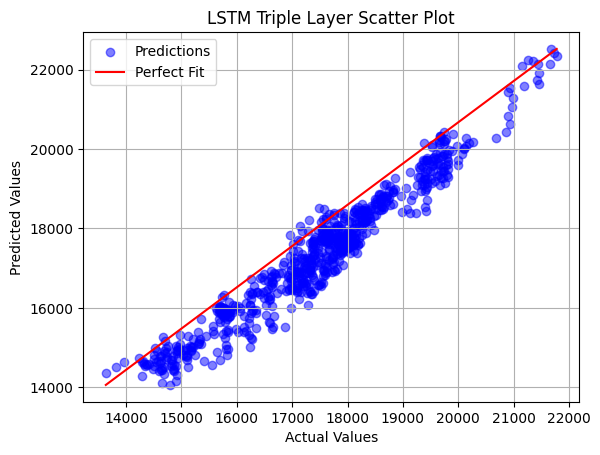

In [80]:
def plot_regression(y_true, y_pred):
  plt.scatter(y_test_actual_LSTM, predictions_LSTM, color='blue', alpha=0.5, label='Predictions')
  plt.plot([min(y_test_actual_LSTM), max(y_test_actual_LSTM)], [min(predictions_LSTM), max(predictions_LSTM)], color='red', linestyle='-', label='Perfect Fit')
  plt.xlabel('Actual Values')
  plt.ylabel('Predicted Values')
  plt.title('LSTM Triple Layer Scatter Plot')
  plt.legend()
  plt.grid(True)
  plt.savefig('Scatterplot_LSTM3.png', dpi=600)
  plt.show()

#Scatter plot
plot_regression(y_test_actual_LSTM,predictions_LSTM)

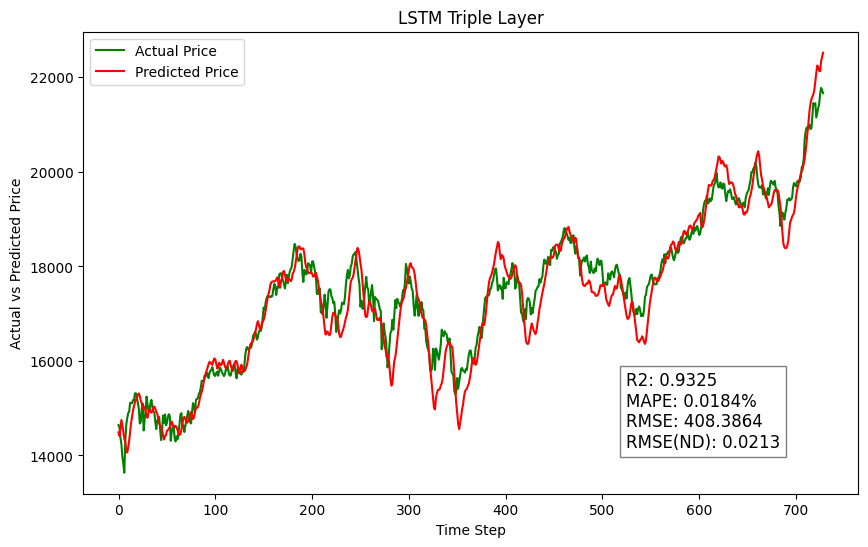

In [81]:
#plot prediction accuracy
plt.figure(figsize=(10, 6))
plt.plot(y_test_actual_LSTM, color='green', label=['Actual Price'])
plt.plot(predictions_LSTM, color='red', label=['Predicted Price'])
plt.legend(['Actual Price', 'Predicted Price'], loc='upper left')

plt.text(0.7, 0.1, f'R2: {r2:.4f}\nMAPE: {mape:.4f}%\nRMSE: {rmse:.4f}\nRMSE(ND): {rmse_normalizeddata:.4f}',
         fontsize=12,
         bbox=dict(facecolor='white', alpha=0.5),
         transform=plt.gca().transAxes)

plt.title('LSTM Triple Layer')
plt.xlabel('Time Step')
plt.ylabel('Actual vs Predicted Price')
plt.savefig('lstm3_0.9325.png', dpi=600)  
plt.show()

##### 4.10 Create and Train the Triple-layer GRU model with optimum hyperparameters

In [ ]:
model_lstm = tf.keras.Sequential()
model_lstm.add(tf.keras.layers.GRU(230, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model_lstm.add(tf.keras.layers.GRU(196, activation='relu', return_sequences=True))
model_lstm.add(tf.keras.layers.GRU(273, activation='relu', return_sequences=False))
model_lstm.add(tf.keras.layers.Dense(1))
model_lstm.compile(optimizer=Nadam(learning_rate=0.00887), loss='mse')
#checkpoint = ModelCheckpoint('model_lstmS1.h5', monitor='loss', verbose=1, save_best_only=True)
early_stopping = EarlyStopping(monitor='loss', patience=5)
model_lstm.fit(X_train, y_train, epochs=200, batch_size=42, validation_data=(X_test, y_test), callbacks=[EarlyStopping(monitor='loss', patience=5)])

predictions_lstm = model_lstm.predict(X_test)
predictions_LSTM = scaler.inverse_transform(predictions_lstm)
y_test_actual_LSTM = scaler.inverse_transform(y_test.reshape(-1, 1))

r2=r2_score(y_test_actual_GRU, predictions_GRU)
print(f"R2: {r2:.4f}")
mape=mean_absolute_percentage_error(y_test_actual_GRU, predictions_GRU)
print(f"MAPE: {mape:.4f}")
mse=mean_squared_error(y_test_actual_GRU, predictions_GRU)
rmse=np.sqrt(mse)
print(f"RMSE: {rmse:.4f}")
mse_normalizeddata=mean_squared_error(y_test, predictions_gru)
rmse_normalizeddata=np.sqrt(mse_normalizeddata)
print(f"RMSE_normalizeddata: {rmse_normalizeddata:.4f}")
mae=mean_absolute_error(y_test_actual_GRU, predictions_GRU)
print(f"MAE: {mae:.4f}")

In [ ]:
#save every model with their respective r2 score
model_lstm.save(f"model_gru3_{r2:.4f}.keras")

In [82]:
#load model with best r2 score
model_gru = load_model('model_gru3_0.9155.keras')
model_gru.predict(X_test)

predictions_gru = model_gru.predict(X_test)
predictions_GRU = scaler.inverse_transform(predictions_gru)
y_test_actual_GRU = scaler.inverse_transform(y_test.reshape(-1, 1))
r2=r2_score(y_test_actual_GRU, predictions_GRU)
print(f"R2: {r2:.4f}")
mape=mean_absolute_percentage_error(y_test_actual_GRU, predictions_GRU)
print(f"MAPE: {mape:.4f}")
mse=mean_squared_error(y_test_actual_GRU, predictions_GRU)
rmse=np.sqrt(mse)
print(f"RMSE: {rmse:.4f}")
mse_normalizeddata=mean_squared_error(y_test, predictions_gru)
rmse_normalizeddata=np.sqrt(mse_normalizeddata)
print(f"RMSE_normalizeddata: {rmse_normalizeddata:.4f}")
mae=mean_absolute_error(y_test_actual_GRU, predictions_GRU)
print(f"MAE: {mae:.4f}")

23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
R2: 0.9155
MAPE: 0.0225
RMSE: 456.8713
RMSE_normalizeddata: 0.0238
MAE: 392.2410


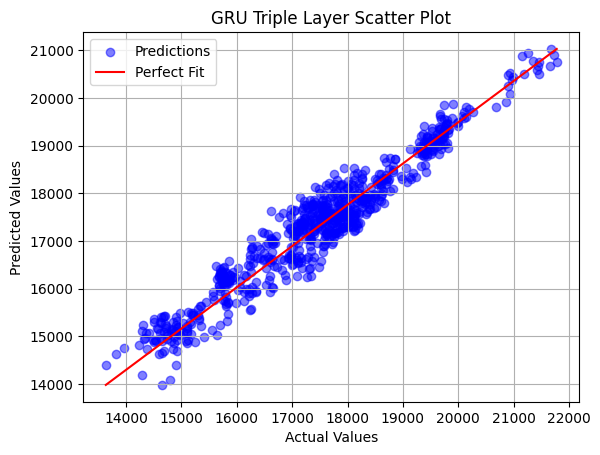

In [83]:
def plot_regression(y_true, y_pred):
  plt.scatter(y_test_actual_GRU, predictions_GRU, color='blue', alpha=0.5, label='Predictions')
  plt.plot([min(y_test_actual_GRU), max(y_test_actual_GRU)], [min(predictions_GRU), max(predictions_GRU)], color='red', linestyle='-', label='Perfect Fit')
  plt.xlabel('Actual Values')
  plt.ylabel('Predicted Values')
  plt.title('GRU Triple Layer Scatter Plot')
  plt.legend()
  plt.grid(True)
  plt.savefig('Scatterplot_GRU3.png', dpi=600)
  plt.show()

#Scatter plot
plot_regression(y_test_actual_GRU,predictions_GRU)

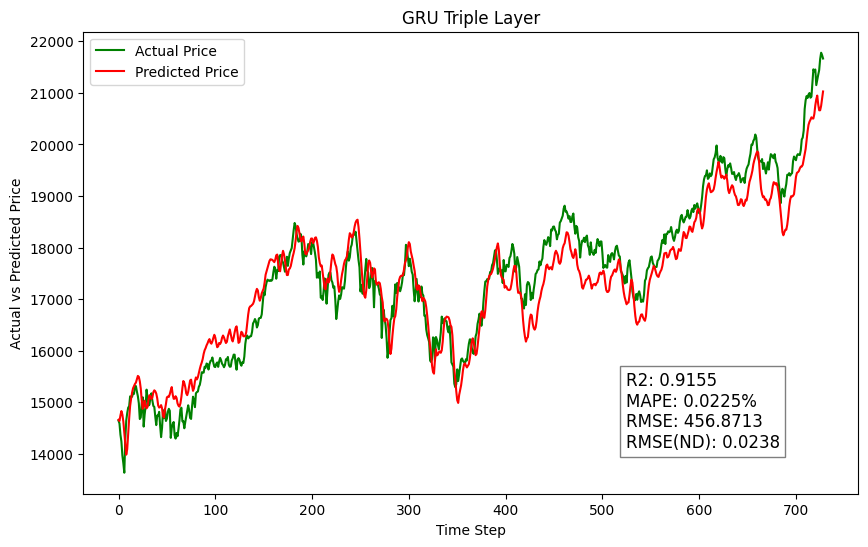

In [84]:
plt.figure(figsize=(10, 6))
plt.plot(y_test_actual_GRU, color='green', label=['Actual Price'])
plt.plot(predictions_GRU, color='red', label=['Predicted Price'])
plt.legend(['Actual Price', 'Predicted Price'], loc='upper left')

plt.text(0.7, 0.1, f'R2: {r2:.4f}\nMAPE: {mape:.4f}%\nRMSE: {rmse:.4f}\nRMSE(ND): {rmse_normalizeddata:.4f}',
         fontsize=12,
         bbox=dict(facecolor='white', alpha=0.5),
         transform=plt.gca().transAxes)

plt.title('GRU Triple Layer')
plt.xlabel('Time Step')
plt.ylabel('Actual vs Predicted Price')
plt.savefig('gru3_0.9155.png', dpi=600)  
plt.show()

##### 4.11 Create and Train the Triple-layer GRU-LSTM model with optimum hyperparameters

In [49]:
model_grulstm = tf.keras.Sequential()
model_grulstm.add(tf.keras.layers.GRU(114, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model_grulstm.add(tf.keras.layers.LSTM(101, activation='relu', return_sequences=True))
model_grulstm.add(tf.keras.layers.GRU(184, activation='relu', return_sequences=True))
model_grulstm.add(tf.keras.layers.LSTM(217, activation='relu', return_sequences=True))
model_grulstm.add(tf.keras.layers.GRU(500, activation='relu', return_sequences=True))
model_grulstm.add(tf.keras.layers.LSTM(229, activation='relu', return_sequences=False))
model_grulstm.add(tf.keras.layers.Dense(1))
model_grulstm.compile(optimizer=Nadam(learning_rate=0.00016), loss='mse')
#checkpoint = ModelCheckpoint('model_grulstmS1.h5', monitor='loss', verbose=1, save_best_only=True)
early_stopping = EarlyStopping(monitor='loss', patience=5)
model_grulstm.fit(X_train, y_train, epochs=200, batch_size=22, validation_data=(X_test, y_test), callbacks=[EarlyStopping(monitor='loss', patience=5)])

predictions_grulstm = model_grulstm.predict(X_test)
predictions_GRULSTM = scaler.inverse_transform(predictions_grulstm)
y_test_actual_GRULSTM = scaler.inverse_transform(y_test.reshape(-1, 1))
dates_test=df['Date'].iloc[split + n_steps:]
r2=r2_score(y_test_actual_GRULSTM, predictions_GRULSTM)
print(f"R2: {r2:.4f}")
mape=mean_absolute_percentage_error(y_test_actual_GRULSTM, predictions_GRULSTM)
print(f"MAPE: {mape:.4f}")
mse=mean_squared_error(y_test_actual_GRULSTM, predictions_GRULSTM)
print(f"MSE: {mse:.4f}")
rmse=np.sqrt(mse)
print(f"RMSE: {rmse:.4f}")
mae=mean_absolute_error(y_test_actual_GRULSTM, predictions_GRULSTM)
print(f"MAE: {mae:.4f}")
mse_n=mean_squared_error(y_test, predictions_grulstm)
rmse_n=np.sqrt(mse_n)
print(f"RMSE of Normalized Data: {rmse_n:.4f}")

Epoch 1/200
133/133 ━━━━━━━━━━━━━━━━━━━━ 21s 72ms/step - loss: 0.0456 - val_loss: 0.0078
Epoch 2/200
133/133 ━━━━━━━━━━━━━━━━━━━━ 9s 64ms/step - loss: 6.8677e-04 - val_loss: 0.0015
Epoch 3/200
133/133 ━━━━━━━━━━━━━━━━━━━━ 9s 65ms/step - loss: 3.6317e-04 - val_loss: 0.0013
Epoch 4/200
133/133 ━━━━━━━━━━━━━━━━━━━━ 8s 61ms/step - loss: 2.4782e-04 - val_loss: 0.0031
Epoch 5/200
133/133 ━━━━━━━━━━━━━━━━━━━━ 8s 60ms/step - loss: 1.9398e-04 - val_loss: 0.0019
Epoch 6/200
133/133 ━━━━━━━━━━━━━━━━━━━━ 8s 60ms/step - loss: 1.6361e-04 - val_loss: 0.0022
Epoch 7/200
133/133 ━━━━━━━━━━━━━━━━━━━━ 8s 60ms/step - loss: 1.3612e-04 - val_loss: 0.0015
Epoch 8/200
133/133 ━━━━━━━━━━━━━━━━━━━━ 8s 63ms/step - loss: 1.3879e-04 - val_loss: 0.0026
Epoch 9/200
133/133 ━━━━━━━━━━━━━━━━━━━━ 8s 61ms/step - loss: 1.1791e-04 - val_loss: 0.0015
Epoch 10/200
133/133 ━━━━━━━━━━━━━━━━━━━━ 8s 61ms/step - loss: 1.1402e-04 - val_loss: 0.0014
Epoch 11/200
133/133 ━━━━━━━━━━━━━━━━━━━━ 8s 62ms/step - loss: 1.0756e-04 - val_lo

In [50]:
#save every model with their respective r2 score
model_grulstm.save(f"model_grulstm3_{r2:.4f}.keras")

In [85]:
#load model with best r2 score
model_grulstm = load_model('model_grulstm3_0.9240.keras')
model_grulstm.predict(X_test)

predictions_grulstm = model_grulstm.predict(X_test)
predictions_GRULSTM = scaler.inverse_transform(predictions_grulstm)
y_test_actual_GRULSTM = scaler.inverse_transform(y_test.reshape(-1, 1))
dates_test=df['Date'].iloc[split + n_steps:]
r2=r2_score(y_test_actual_GRULSTM, predictions_GRULSTM)
print(f"R2: {r2:.4f}")
mape=mean_absolute_percentage_error(y_test_actual_GRULSTM, predictions_GRULSTM)
print(f"MAPE: {mape:.4f}")
mse=mean_squared_error(y_test_actual_GRULSTM, predictions_GRULSTM)
print(f"MSE: {mse:.4f}")
rmse=np.sqrt(mse)
print(f"RMSE: {rmse:.4f}")
mae=mean_absolute_error(y_test_actual_GRULSTM, predictions_GRULSTM)
print(f"MAE: {mae:.4f}")
mse_n=mean_squared_error(y_test, predictions_grulstm)
rmse_n=np.sqrt(mse_n)
print(f"RMSE of Normalized Data: {rmse_n:.4f}")

23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
R2: 0.9240
MAPE: 0.0193
MSE: 187588.0392
RMSE: 433.1143
MAE: 335.4060
RMSE of Normalized Data: 0.0226


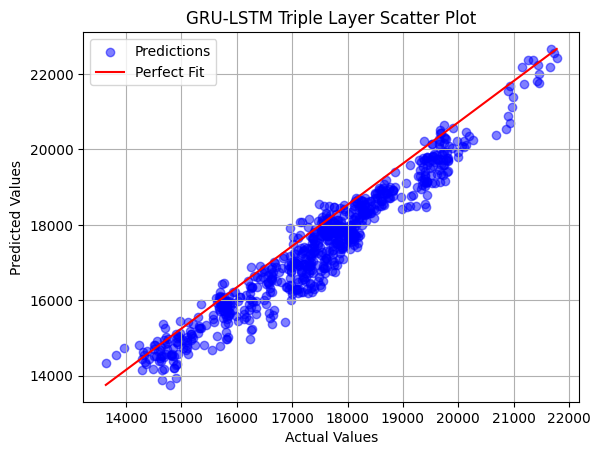

In [86]:
def plot_regression(y_true, y_pred):
  plt.scatter(y_test_actual_GRULSTM, predictions_GRULSTM, color='blue', alpha=0.5, label='Predictions')
  plt.plot([min(y_test_actual_GRULSTM), max(y_test_actual_GRULSTM)], [min(predictions_GRULSTM), max(predictions_GRULSTM)], color='red', linestyle='-', label='Perfect Fit')
  plt.xlabel('Actual Values')
  plt.ylabel('Predicted Values')
  plt.title('GRU-LSTM Triple Layer Scatter Plot')
  plt.legend()
  plt.grid(True)
  plt.savefig('Scatterplot_GRULSTM3.png', dpi=600)
  plt.show()

#Scatter plot
plot_regression(y_test_actual_GRULSTM,predictions_GRULSTM)

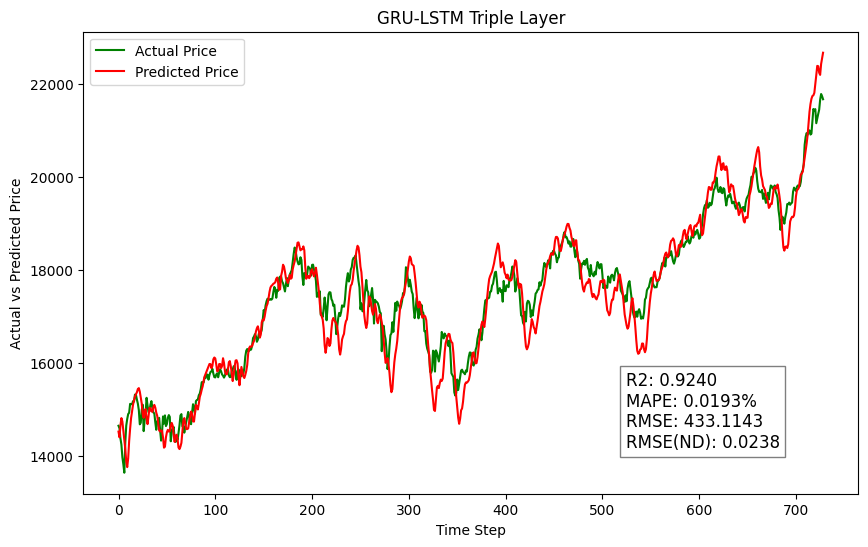

In [87]:
#plot prediction accuracy
plt.figure(figsize=(10, 6))
plt.plot(y_test_actual_GRULSTM, color='green', label=['Actual Price'])
plt.plot(predictions_GRULSTM, color='red', label=['Predicted Price'])
plt.legend(['Actual Price', 'Predicted Price'], loc='upper left')

plt.text(0.7, 0.1, f'R2: {r2:.4f}\nMAPE: {mape:.4f}%\nRMSE: {rmse:.4f}\nRMSE(ND): {rmse_normalizeddata:.4f}',
         fontsize=12,
         bbox=dict(facecolor='white', alpha=0.5),
         transform=plt.gca().transAxes)

plt.title('GRU-LSTM Triple Layer')
plt.xlabel('Time Step')
plt.ylabel('Actual vs Predicted Price')
plt.savefig('grulstm3_0.9240.png', dpi=600) 
plt.show()

##### 4.12 Create and Train the Triple-layer LSTM-GRU model with optimum hyperparameters

In [44]:
model_lstmgru = tf.keras.Sequential()
model_lstmgru.add(tf.keras.layers.LSTM(176, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model_lstmgru.add(tf.keras.layers.GRU(126, activation='relu', return_sequences=True))
model_lstmgru.add(tf.keras.layers.LSTM(430, activation='relu', return_sequences=True))
model_lstmgru.add(tf.keras.layers.GRU(146, activation='relu', return_sequences=True))
model_lstmgru.add(tf.keras.layers.LSTM(32, activation='relu', return_sequences=True))
model_lstmgru.add(tf.keras.layers.GRU(83, activation='relu', return_sequences=False))
model_lstmgru.add(tf.keras.layers.Dense(1))
model_lstmgru.compile(optimizer=Nadam(learning_rate=0.00055), loss='mse')
#checkpoint = ModelCheckpoint('model_grulstmS1.h5', monitor='loss', verbose=1, save_best_only=True)
#early_stopping = EarlyStopping(monitor='loss', patience=5)
model_lstmgru.fit(X_train, y_train, epochs=200, batch_size=44, validation_data=(X_test, y_test), callbacks=[EarlyStopping(monitor='loss', patience=5)])


predictions_lstmgru = model_lstmgru.predict(X_test)
predictions_LSTMGRU = scaler.inverse_transform(predictions_lstmgru)
y_test_actual_LSTMGRU = scaler.inverse_transform(y_test.reshape(-1, 1))

dates_test=df['Date'].iloc[split + n_steps:]
r2=r2_score(y_test_actual_LSTMGRU, predictions_LSTMGRU)
print(f"R2: {r2:.4f}")

mape=mean_absolute_percentage_error(y_test_actual_LSTMGRU, predictions_LSTMGRU)
print(f"MAPE: {mape:.4f}")

mse=mean_squared_error(y_test_actual_LSTMGRU, predictions_LSTMGRU)
print(f"MSE: {mse:.4f}")
rmse=np.sqrt(mse)
print(f"RMSE: {rmse:.4f}")

mae=mean_absolute_error(y_test_actual_LSTMGRU, predictions_LSTMGRU)
print(f"MAE: {mae:.4f}")

mse_n=mean_squared_error(y_test, predictions_lstmgru)
rmse_n=np.sqrt(mse_n)
print(f"RMSE of Normalized Data: {rmse_n:.4f}")

Epoch 1/200
67/67 ━━━━━━━━━━━━━━━━━━━━ 15s 64ms/step - loss: 0.0487 - val_loss: 0.0609
Epoch 2/200
67/67 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 0.0013 - val_loss: 0.0558
Epoch 3/200
67/67 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 6.3380e-04 - val_loss: 0.0142
Epoch 4/200
67/67 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - loss: 3.9255e-04 - val_loss: 0.0057
Epoch 5/200
67/67 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - loss: 2.8652e-04 - val_loss: 0.0025
Epoch 6/200
67/67 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - loss: 1.9076e-04 - val_loss: 0.0028
Epoch 7/200
67/67 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - loss: 1.7602e-04 - val_loss: 0.0073
Epoch 8/200
67/67 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - loss: 1.8473e-04 - val_loss: 0.0026
Epoch 9/200
67/67 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - loss: 1.4976e-04 - val_loss: 0.0051
Epoch 10/200
67/67 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - loss: 1.5897e-04 - val_loss: 0.0013
Epoch 11/200
67/67 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - loss: 1.3674e-04 - val_loss: 0.0023
Epoch 12/200
67

In [ ]:
#save every model with their respective r2 score
model_lstmgru.save(f"model_lstmgru3_{r2:.4f}.keras")

In [88]:
#load model with best r2 score
model_lstmgru = load_model('model_lstmgru3_0.9237.keras')
model_lstmgru.predict(X_test)

predictions_lstmgru = model_lstmgru.predict(X_test)
predictions_LSTMGRU = scaler.inverse_transform(predictions_lstmgru)
y_test_actual_LSTMGRU = scaler.inverse_transform(y_test.reshape(-1, 1))

dates_test=df['Date'].iloc[split + n_steps:]
r2=r2_score(y_test_actual_LSTMGRU, predictions_LSTMGRU)
print(f"R2: {r2:.4f}")

mape=mean_absolute_percentage_error(y_test_actual_LSTMGRU, predictions_LSTMGRU)
print(f"MAPE: {mape:.4f}")

mse=mean_squared_error(y_test_actual_LSTMGRU, predictions_LSTMGRU)
print(f"MSE: {mse:.4f}")
rmse=np.sqrt(mse)
print(f"RMSE: {rmse:.4f}")

mae=mean_absolute_error(y_test_actual_LSTMGRU, predictions_LSTMGRU)
print(f"MAE: {mae:.4f}")

mse_n=mean_squared_error(y_test, predictions_lstmgru)
rmse_n=np.sqrt(mse_n)
print(f"RMSE of Normalized Data: {rmse_n:.4f}")

23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 56ms/step
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
R2: 0.9237
MAPE: 0.0201
MSE: 188413.4787
RMSE: 434.0662
MAE: 345.9344
RMSE of Normalized Data: 0.0226


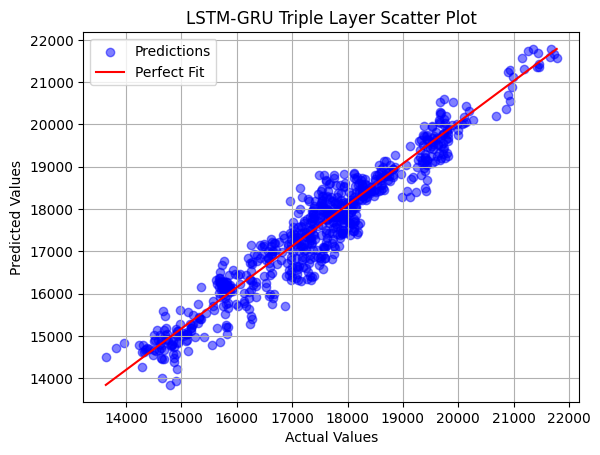

In [89]:
def plot_regression(y_true, y_pred):
  plt.scatter(y_test_actual_LSTMGRU, predictions_LSTMGRU, color='blue', alpha=0.5, label='Predictions')
  plt.plot([min(y_test_actual_LSTMGRU), max(y_test_actual_LSTMGRU)], [min(predictions_LSTMGRU), max(predictions_LSTMGRU)], color='red', linestyle='-', label='Perfect Fit')
  plt.xlabel('Actual Values')
  plt.ylabel('Predicted Values')
  plt.title('LSTM-GRU Triple Layer Scatter Plot')
  plt.legend()
  plt.grid(True)
  plt.savefig('Scatterplot_LSTMGRU3.png', dpi=600)
  plt.show()

#Scatter plot
plot_regression(y_test_actual_LSTMGRU,predictions_LSTMGRU)

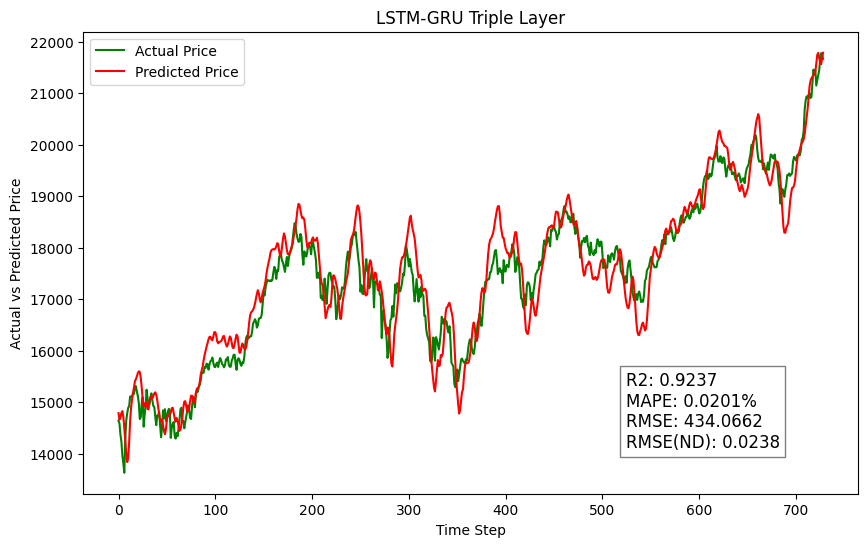

In [90]:
#plot prediction accuracy
plt.figure(figsize=(10, 6))
plt.plot(y_test_actual_LSTMGRU, color='green', label=['Actual Price'])
plt.plot(predictions_LSTMGRU, color='red', label=['Predicted Price'])
plt.legend(['Actual Price', 'Predicted Price'], loc='upper left')

plt.text(0.7, 0.1, f'R2: {r2:.4f}\nMAPE: {mape:.4f}%\nRMSE: {rmse:.4f}\nRMSE(ND): {rmse_normalizeddata:.4f}',
         fontsize=12,
         bbox=dict(facecolor='white', alpha=0.5),
         transform=plt.gca().transAxes)

plt.title('LSTM-GRU Triple Layer')
plt.xlabel('Time Step')
plt.ylabel('Actual vs Predicted Price')
plt.savefig('lstmgru3_0.9237.png', dpi=600)  
plt.show()

## Perform Statistical tests

In [40]:
import scipy
def perform_normality_test(data1, data2):
  print("Performaing Normality Tests\n")
  print("Data1: ")
  print(scipy.stats.normaltest(data1))
  print("Data 2:")
  print(scipy.stats.normaltest(data2))

def perform_ttest(data1, data2):
  print("\nTwo-sample ttest")
  print(scipy.stats.ttest_ind(data1, data2, equal_var = False))  # It does not require variences to be equal.

def perform_statistical_analysis(data1, data2):
  perform_normality_test(data1, data2)
  perform_ttest(data1, data2)

In [ ]:
#Perform normality test or two-sample t-test
data1 = best RMSE/MAPE/R2 values of lstm/gru/gru-lstm/lstm-gru models
data2 = best RMSE/MAPE/R2 values of lstm/gru/gru-lstm/lstm-gru models
perform_statistical_analysis(data1, data2)